# Telegram Analysis

## Prepare environment

In [1]:
"""
Set flag to true, if you work in visual studio code (connected to custom docker)
Set flag to false, if you work in browser (jupyter notebook ui from custom docker)
"""
C_LOCAL                 = True

"""
Set flag to true, if you want process no long term running tasks
"""
C_SHORT_RUN             = True

"""
Resolve new urls?
Set flag to false, if you dont want to resolve new urls
"""
C_RESOLVE_NEW_URLS      = False

"""
Load Piplelines?
"""
C_LOAD_PIPELINES        = True

"""
Load DataSets
Ava:    ["dataSet0", "dataSet1", "dataSet1a", "dataSet2"]
Htdocs: ["dataSet0", "dataSet1a", "dataSet2"]
Req:    ["dataSet0]
"""
C_LOAD_DATASET          = ["dataSet0", "dataSet1a"]

"""
Time Plot Freq
e.g. 1M = 1 Month
e.g. 1W = 1 Week
e.g. 1D = 1 Day
"""
C_TIME_PLOT_FREQ        = "6M"

In [2]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Import url libs
from urllib.parse import urlparse
from collections import Counter
import requests

# File Handler Lib
from pathlib import Path

# Set graph widget (used by jupyter notebook)
#%matplotlib notebook   #interactive graphs
%matplotlib inline

In [3]:
# Install and import Graph Lib
import networkx as nx
#! pip install pydot

In [4]:
# Install and import  JSON Lib
#! pip install demjson
import demjson
#import json

In [5]:
# Install and import Natural Language Toolkit
#! pip install nltk
import nltk

# Ngrams
import re
from nltk.util import ngrams

# Stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Gensim and pyLDAvis
#! pip install gensim
#! pip install pyLDAvis

import gensim

from gensim.utils import simple_preprocess

import gensim.corpora as corpora

from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis

import os

# TODO Set to ignore?
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("once")

In [7]:
# Install and import demoji
# Dont exists on conda
import sys
!{sys.executable} -m pip install demoji

import demoji
demoji.download_codes()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... OK (Got response in 0.44 seconds)
Writing emoji data to /home/jovyan/.demoji/codes.json ...
... OK


In [8]:
# Install and import WordCloud
#! pip install wordcloud
from wordcloud import WordCloud

/opt/conda/lib/python3.8/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/opt/conda/lib/python3.8/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [9]:
#!{sys.executable} -m pip install lxml
from lxml.html import fromstring

In [10]:
# Bert and co.
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

In [11]:
# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Set plot style
plt.style.use('ggplot')

In [13]:
# Set env vars
if(C_LOCAL == True):
    dir_var = "./work/notebooks/"
else:
    dir_var = "./"

dir_var_output = dir_var + "output/"

dir_var_cache= dir_var + "cache/"

# Debug output
! echo "- Workdir -"
! ls -al $dir_var

! echo
! echo "- Outputdir -"
! ls -al $dir_var_output

! echo
! echo "- Cachedir -"
! ls -al $dir_var_cache

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
- Workdir -
total 6684
drwxr-xr-x 13 jovyan users     416 Jan 20 14:59 .
drwxr-xr-x 10 root   root      320 Jan 18 07:37 ..
-rw-r--r--  1 jovyan users      46 Jan 12 12:10 additionalStopwords.txt
drwxr-xr-x  9 jovyan users     288 Jan 18 07:37 cache
-rwxr-xr-x  1 jovyan users     273 Jan 18 07:37 clean-notebook.sh
drwxr-xr-x  8 jovyan users     256 Jan 13 09:30 data
-rw-r--r--  1 jovyan users    6148 Dec 22 16:15 .DS_Store
-rw-r--r--  1 jovyan users   39822 Jan 20 09:35 HuggingFace.ipynb
-rw-r--r--  1 jovyan users   12522 Jan 13 15:38 inputFiles.csv
drwxr-xr-x  3 jovyan users      96 Dec 20 10:30 .ipynb_checkpoints
drwxr-xr-x  6 jovyan us

### Global functions

In [14]:
dictGloStopwatches = dict()

# Start timer (for reporting)
def gloStartStopwatch(key):
    print("[Stopwatch started >>" + str(key) + "<<]")
    dictGloStopwatches[key] = time.time()

# Stop timer (for reporting)
def gloStopStopwatch(key):
    endTime     = time.time()
    startTime   = dictGloStopwatches[key]
    print("[Stopwatch stopped >>" + str(key) + "<< (" + '{:5.3f}s'.format(endTime-startTime) + ")]")

In [15]:
"""
Check if text is json formatted

param   text        InputText
param   singleMode  Boolean (set to true, if text is part of a message)
"""
def gloCheckIsTextJsonFormatted(text, singleMode):
    textString = str(text)
    if      (singleMode == False and textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    elif    (singleMode == True and textString.startswith("{") == True and textString.endswith("}") == True):
        return True
    else:
        return False

In [16]:
def gloReplaceGermanChars(inputText):

    inputText = inputText.replace("ö", "oe")
    inputText = inputText.replace("ü", "ue")
    inputText = inputText.replace("ä", "ae")

    inputText = inputText.replace("Ö", "Oe")
    inputText = inputText.replace("Ü", "Ue")
    inputText = inputText.replace("Ä", "Ae")

    inputText = inputText.replace("ß", "ss")
    
    return inputText

In [17]:
# Rm unsafe chars
def gloConvertToSafeString(text):
    text = demoji.replace(text, "")
    text = gloReplaceGermanChars(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    #text = text.encode('ascii', 'ignore')
    #text = text.decode('ascii')
    return text

# Generate unique chat name
def gloConvertToSafeChatName(chatName):
    chatName = gloConvertToSafeString(chatName)
    return chatName[:30]

In [18]:
# Dict File Cache
dictFileCache = {}

# Write dict to file (CSV)
def gloWriteDictToFile(filename, targetDict):
    dictFileCache = {} #Clear cache
    d = pd.DataFrame.from_dict(targetDict, orient="index")
    d.to_csv(dir_var_cache + filename, header=False)

# Read dict from file (CSV)
def gloReadDictFromFile(filename):
    # Cache?
    if(filename in dictFileCache):
        return dictFileCache[filename]

    d = pd.read_csv(dir_var_cache + filename, header=None, index_col=0, squeeze=True)
    retDict = d.to_dict()

    dictFileCache[filename] = retDict #Add to cache

    return retDict

# Init csv file if not exists
def gloInitFileDict(filename):
    f = Path(dir_var_cache + filename)
    if(f.exists() == False):
        print("Init cache file >>" + filename + "<<")
        f.touch()
        gloWriteDictToFile(filename, {"initKey": "initValue"})
    else:
        print("Cache already exists >>" + filename + "<<")

In [19]:
# Check if is already cached
def gloCheckIsAlreadyCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    if(targetKey in targetDict.keys()):
        return True
    else:
        return False

# Add key to cache
def gloAddToCache(filename, targetKey, targetValue):
    targetDict = gloReadDictFromFile(filename)
    targetDict[targetKey] = targetValue
    gloWriteDictToFile(filename, targetDict)

# Get key from cache
def gloGetCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    return targetDict[targetKey]

In [20]:
# param rowID e.g. procTDSafeText
def gloGenerateTextFromChat(df, rowID):
    df = df.copy()
    df = df[df.procEvalIsValidText == True]
    
    # Iterate over text (global text from group)
    textList = []
    for index, row in df.iterrows():
        textList.append(" " + row[rowID])
        
    textString = ''.join(textList)

    return textString

#### Init Cache Files

In [21]:
gloInitFileDict("resolved-urls.csv")

Cache already exists >>resolved-urls.csv<<


In [22]:
gloInitFileDict("resolved-youtube.csv")

Cache already exists >>resolved-youtube.csv<<


#### Load Pipelines

In [23]:
dictPipelines = {}

def loadPipelines():

    if(C_LOAD_PIPELINES == False):
        print("Skip loading pipelines")
        return list()

    gloStartStopwatch("Load Pipelines")
    

    gloStartStopwatch("Load ner-xlm-Roberta")
    dictPipelines["ner-xlm-roberta"] = pipeline(
        'ner', 
        model='xlm-roberta-large-finetuned-conll03-german',
        tokenizer='xlm-roberta-large-finetuned-conll03-german'
    )
    gloStopStopwatch("Load ner-xlm-Roberta")

    gloStartStopwatch("Load ner-Bert")
    dictPipelines["ner-bert"] = pipeline(
        'ner', 
        model='fhswf/bert_de_ner',
        tokenizer='fhswf/bert_de_ner'
    )
    gloStopStopwatch("Load ner-Bert")

    gloStartStopwatch("Load sen-Bert")
    dictPipelines["sen-bert"] = pipeline(
        'sentiment-analysis', 
        model='nlptown/bert-base-multilingual-uncased-sentiment',
        tokenizer='nlptown/bert-base-multilingual-uncased-sentiment'
    )
    gloStopStopwatch("Load sen-Bert")

    gloStartStopwatch("Load text-gen-gpt2")
    dictPipelines["text-gen-gpt2"] = pipeline(
        'text-generation', 
        model='dbmdz/german-gpt2',
        tokenizer='dbmdz/german-gpt2'
    )
    gloStopStopwatch("Load text-gen-gpt2")


    gloStopStopwatch("Load Pipelines")

    return dictPipelines.keys()

pipelineKeys = loadPipelines()

print()
print(str(pipelineKeys))

[Stopwatch started >>Load Pipelines<<]
[Stopwatch started >>Load ner-xlm-Roberta<<]
[Stopwatch stopped >>Load ner-xlm-Roberta<< (27.543s)]
[Stopwatch started >>Load ner-Bert<<]
[Stopwatch stopped >>Load ner-Bert<< (11.388s)]
[Stopwatch started >>Load sen-Bert<<]
[Stopwatch stopped >>Load sen-Bert<< (13.002s)]
[Stopwatch started >>Load text-gen-gpt2<<]
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
[Stopwatch stopped >>Load text-gen-gpt2<< (13.991s)]
[Stopwatch stopped >>Load Pipelines<< (65.946s)]

dict_keys(['ner-xlm-roberta', 'ner-bert', 'sen-bert', 'text-gen-gpt2'])


## Process input jobs

In [24]:
gloStartStopwatch("Global notebook")

[Stopwatch started >>Global notebook<<]


In [25]:
# Read jobs from file
dfInputFiles = pd.read_csv(dir_var + "inputFiles.csv", sep=";")

In [26]:
dfFilter = pd.DataFrame()

for dS in C_LOAD_DATASET:
    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputDesc == dS])

dfInputFiles = dfFilter

### Overview input jobs

In [27]:
dfInputFiles

inputName  \
47                 ATTILA HILDMANN   
48       Oliver Janich oeffentlich   
49            Eva Herman Offiziell   
50     Xavier Naidoo (inoffiziell)   
58                  FREIHEITS-CHAT   
60           FREIHEITSCHAT - BLITZ   
98  Livestreaming fuer Deutschland   

                                            inputPath          inputType  \
47       DS-05-01-2021/ChatExport_2021-01-05-hildmann     public_channel   
48         DS-05-01-2021/ChatExport_2021-01-05-janich     public_channel   
49      DS-05-01-2021/ChatExport_2021-01-05-evaherman     public_channel   
50         DS-05-01-2021/ChatExport_2021-01-05-xavier     public_channel   
58  DS-05-01-2021a/ChatExport_2021-01-05-freiheits...  public_supergroup   
60  DS-05-01-2021a/ChatExport_2021-01-05-freiheits...  public_supergroup   
98  DS-05-01-2021a/ChatExport_2021-01-05-liveFuerD...  public_supergroup   

        inputId  inputDesc inputDownloadType  
47  10034163583   dataSet0          onlyText  
48   9808932799   dataSet0          onlyText  
49   9915108907   dataSet0          onlyText  
50   9874390332   dataSet0          onlyText  
58   9717909816  dataSet1a          onlyText  
60   9943834900  dataSet1a          onlyText  
98   9943535763  dataSet1a          onlyText

### Transform data into DataFrmaes

In [28]:
# Convert to DataFrame Meta (Chat Meta)
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + "data/" + filePath + "/result.json", encoding='utf-8')
    return dF

# Convert to DataFrame Messages (Chat Messages)
def convertToDataFrameMessages(filePath):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# https://stackoverflow.com/questions/6718633/python-regular-expression-again-match-url
def getUrlRegex():
    return "((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)"

def gefGetHashtagRegex():
    return "#(\w+)"

def hashTagExtractHashTags(inputText):

    inputText = str(inputText)

    inputText = re.sub('\n', ' ', inputText) # Replace \n
    inputText = demoji.replace(inputText, " ") # Rm emoji
    inputText = gloReplaceGermanChars(inputText) # Replace german chars

    return re.findall(gefGetHashtagRegex(), inputText)

def urlExtractUrls(inputText):
    return re.findall(getUrlRegex(), str(inputText))

def urlRemoveUrls(inputText):
    return re.sub(getUrlRegex(), " ", str(inputText))

<>:3: DeprecationWarning: invalid escape sequence \.
<>:6: DeprecationWarning: invalid escape sequence \w


In [30]:
"""
Get params from extractedTextData
See cell below (key)
"""
def getExtractedTextDataParam(key, extractedTextData):

    a,b,c,d,e,f,g = extractedTextData

    if(key == 0):

        return urlRemoveUrls(a)

    elif(key == 1):

        before = b
        extracted = urlExtractUrls(a)

        after = before
        after.extend(extracted)

        """
        if(str(extracted) != "[]"):
            # TODO: Fix return bug
            print("Debug >>" + str(before) + "/" + str(extracted) + ">>" + str(after) + "<<")
        """

        return after

    elif(key == 2):

        # TODO: Refactor dont take it from extractedTextData
        return hashTagExtractHashTags(a)

    else:
        switcher = {
            3: d,
            4: e,
            5: f,
            6: g
        }
        return switcher.get(key)

In [31]:
"""
Extract text data (see cell above key)
See cell above (key)

param   procIsJsonFormatted Boolean (is text json formatted?)
param   text                String  (text from message) 

return
a   procText            Plain Text
b   processedURLs       Array of URLs in Text
c   processedHashtags   Array of Hashtags in Text #TODO: RM
d   processedBolds      Array of Bold Items in Text
e   processedItalics    Array of Italic Items in Text
f   processedUnderlines Array of Underlined Items in Text
g   processedEmails     Array of E-Mails in Text
"""
def extractTextData(procIsJsonFormatted, text):
    
    # 3 returns in this function...
    
    processedURLs       = list()
    processedHashtags   = list() # TODO: RM
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(procIsJsonFormatted != True):
        #Is not JSON formatted (return normal text)
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is is JSON formatted (try to parse)
        try:
            returnList = []
            jsonList = demjson.decode(str(text), encoding='utf8')

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isJsonSubString = gloCheckIsTextJsonFormatted(messageString, singleMode = True)

                if(isJsonSubString):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        #returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        #processedHashtags.append(subJsonString["text"]) # TODO: Refactor: Dont add hashtags here!
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unkown json type >>" + str(subJsonType) + "<< (ignore) >>" + str(text) + "<<")

                else:
                    # Is no json formatted sub string (append text)
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            # Parser error (set inputText to returnText)
            print("- Warn: Json parser error (set inputText to returnText) >>" + str(text) + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

In [32]:
def evalIsValidText(procTDTextLength):
    if(procTDTextLength > 0):
        return True
    else:
        return False

In [33]:
def evalContainsSomething(att):
    if(str(att) == "nan"):
        return False
    else:
        return True

In [34]:
def evalNonEmptyList(att):
    if(str(att) == "[]"):
        return False
    else:
        return True

In [35]:
gloStartStopwatch("Extract Text Data")

# Add Key = filePath / Value = DataFrame (Chat Meta)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Chat Message)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    gloStartStopwatch("TD-Extract " + fP)
    dfMessages                          = convertToDataFrameMessages(fP)

    # Short run
    if(C_SHORT_RUN):
        print("Short run active!")
        dfMessages = dfMessages.head(1000)

    # Get chat attributes and check if message is json formatted
    dfMessages["procChatFilePath"]      = fP
    dfMessages["procChatType"]          = dictMeta[fP].type.iloc[0]
    dfMessages["procIsJsonFormatted"]   = dfMessages["text"].apply(gloCheckIsTextJsonFormatted, singleMode = False)
    
    # Extract Text Data
    dfMessages["tmpExtractedTD"]        = dfMessages.apply(lambda x: extractTextData(x.procIsJsonFormatted, x.text), axis=1)

    # Extract Text Data (params)
    dfMessages["procTDText"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(0, x.tmpExtractedTD), axis=1)
    dfMessages["procTDURLs"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(1, x.tmpExtractedTD), axis=1)
    dfMessages["procTDHashtags"]        = dfMessages.apply(lambda x: getExtractedTextDataParam(2, x.tmpExtractedTD), axis=1)
    dfMessages["procTDBolds"]           = dfMessages.apply(lambda x: getExtractedTextDataParam(3, x.tmpExtractedTD), axis=1)
    dfMessages["procTDItalics"]         = dfMessages.apply(lambda x: getExtractedTextDataParam(4, x.tmpExtractedTD), axis=1)
    dfMessages["procTDUnderlines"]      = dfMessages.apply(lambda x: getExtractedTextDataParam(5, x.tmpExtractedTD), axis=1)
    dfMessages["procTDEmails"]          = dfMessages.apply(lambda x: getExtractedTextDataParam(6, x.tmpExtractedTD), axis=1)

    # Process text again
    dfMessages['procTDCleanText']           = dfMessages['procTDText'].map(lambda x: re.sub('\n', ' ', x)) # Replace \n
    dfMessages['procTDEmojis']              = dfMessages['procTDCleanText'].map(lambda x: demoji.findall_list(x, desc = False)) # Filter out emoji
    dfMessages['procTDEmojisDesc']          = dfMessages['procTDCleanText'].map(lambda x: demoji.findall_list(x, desc = True)) # Filter out emoji with desc
    dfMessages['procTDCleanText']           = dfMessages['procTDCleanText'].map(lambda x: demoji.replace(x, " ")) # Rm emoji
    dfMessages['procTDCleanText']           = dfMessages['procTDCleanText'].map(lambda x: gloReplaceGermanChars(x)) # Replace german chars
    dfMessages['procTDSafeText']            = dfMessages['procTDCleanText'].map(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x)) # Filter out . ! ? ... (get only safe chars)
    dfMessages['procTDSafeLowercaseText']   = dfMessages['procTDSafeText'].map(lambda x: x.lower()) # To lower

    # Calc text size
    dfMessages["procTDTextLength"]      = dfMessages["procTDCleanText"].str.len()

    # Add columns (if not exists)
    if "photo" not in dfMessages:
        print("- Debug: Add column >>photo<<")
        dfMessages["photo"] = np.nan

    if "file" not in dfMessages:
        print("- Debug: Add column >>file<<")
        dfMessages["file"] = np.nan

    if "edited" not in dfMessages:
        print("- Debug: Add column >>edited<<")
        dfMessages["edited"] = np.nan

    if "forwarded_from" not in dfMessages:
        print("- Debug: Add column >>forwarded_from<<")
        dfMessages["forwarded_from"] = np.nan

    # Evaluate attributes
    dfMessages["procEvalIsValidText"]   = dfMessages.procTDTextLength.apply(evalIsValidText)

    dfMessages["procEvalContainsPhoto"] = dfMessages.photo.apply(evalContainsSomething)
    dfMessages["procEvalContainsFile"]  = dfMessages.file.apply(evalContainsSomething) 
    dfMessages["procEvalIsEdited"]      = dfMessages.edited.apply(evalContainsSomething)
    dfMessages["procEvalIsForwarded"]   = dfMessages.forwarded_from.apply(evalContainsSomething)
    
    dfMessages["procEvalContainsUrl"]              = dfMessages.procTDURLs.apply(evalNonEmptyList)
    dfMessages["procEvalContainsHashtag"]          = dfMessages.procTDHashtags.apply(evalNonEmptyList)
    dfMessages["procEvalContainsBoldItem"]         = dfMessages.procTDBolds.apply(evalNonEmptyList)
    dfMessages["procEvalContainsItalicItem"]       = dfMessages.procTDItalics.apply(evalNonEmptyList)
    dfMessages["procEvalContainsUnderlineItem"]    = dfMessages.procTDUnderlines.apply(evalNonEmptyList)
    dfMessages["procEvalContainsEmailItem"]        = dfMessages.procTDEmails.apply(evalNonEmptyList)
    dfMessages['procEvalContainsEmojiItem']        = dfMessages.procTDEmojis.apply(evalNonEmptyList)

    # Add to dict    
    dictMessages[fP] = dfMessages
    gloStopStopwatch("TD-Extract " + fP)

# All Messages to DataFrame
gloStartStopwatch("Generate global DataFrame")
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)
gloStopStopwatch("Generate global DataFrame")

gloStopStopwatch("Extract Text Data")

[Stopwatch started >>Extract Text Data<<]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-hildmann<<]
Short run active!
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-hildmann<< (3.412s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-janich<<]
Short run active!
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-janich<< (6.783s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-evaherman<<]
Short run active!
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-evaherman<< (4.906s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-xavier<<]
Short run active!
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-xavier<< (7.486s)]
[Stopwatch started >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChat<<]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent c

TypeError: object of type 'NoneType' has no len()

## Meta-Queries

In [35]:
# Test
#df = dfAllDataMessages[["date", "text", "procTDCleanText", "procTDHashtags", "procEvalContainsHashtag", "procIsJsonFormatted"]].copy()

#df = df[df.procIsJsonFormatted == True]
#df = df[df.procEvalContainsHashtag == True]
#df = df[df.procTDCleanText.str.contains("#")]

#df.head(10)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Type of channels

In [36]:
dfInputFiles.inputType.value_counts()

public_channel       4
public_supergroup    3
Name: inputType, dtype: int64

### Define queries

In [37]:
def queryChatId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [38]:
def queryChatName(filePath):
    dfMeta      = dictMeta[filePath].copy()
    chatName    = str(dfMeta["name"].iloc[0])
    chatName    = gloConvertToSafeChatName(chatName)
    return chatName

In [39]:
def queryChatType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [40]:
def queryNumberOfMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [41]:
def queryNumberOfMessagesByAttEqTrue(filePath, attKey):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages[attKey] == True]
    return len(dfMessages.index)

### Execute queries

In [42]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["qryChatId"]                        = dfQueryMeta.inputPath.apply(queryChatId)
dfQueryMeta["qryChatName"]                      = dfQueryMeta.inputPath.apply(queryChatName)
dfQueryMeta["qryChatType"]                      = dfQueryMeta.inputPath.apply(queryChatType)
dfQueryMeta["qryNumberOfMessages"]              = dfQueryMeta.inputPath.apply(queryNumberOfMessages)

dfQueryMeta["qryNumberOfFormattedTextMessages"] = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procIsJsonFormatted"), axis=1)

dfQueryMeta["qryNumberOfValidTextMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsValidText"), axis=1)

dfQueryMeta["qryNumberOfPhotos"]                = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsPhoto"), axis=1)
dfQueryMeta["qryNumberOfFiles"]                 = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsFile"), axis=1)
dfQueryMeta["qryNumberOfEditedMessages"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsEdited"), axis=1)
dfQueryMeta["qryNumberOfForwardedMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsForwarded"), axis=1)

dfQueryMeta["qryNumberOfMessagesWithUrl"]           = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsUrl"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithHashtag"]       = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsHashtag"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithBold"]          = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsBoldItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithItalic"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsItalicItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithUnderline"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsUnderlineItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmail"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsEmailItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmoji"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsEmojiItem"), axis=1)

dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False)

inputPath    qryChatId  \
47       DS-05-01-2021/ChatExport_2021-01-05-hildmann  10034163583   
48         DS-05-01-2021/ChatExport_2021-01-05-janich   9808932799   
49      DS-05-01-2021/ChatExport_2021-01-05-evaherman   9915108907   
50         DS-05-01-2021/ChatExport_2021-01-05-xavier   9874390332   
58  DS-05-01-2021a/ChatExport_2021-01-05-freiheits...   9717909816   
60  DS-05-01-2021a/ChatExport_2021-01-05-freiheits...   9943834900   
98  DS-05-01-2021a/ChatExport_2021-01-05-liveFuerD...   9943535763   

                       qryChatName        qryChatType  qryNumberOfMessages  \
47                ATTILA HILDMANN      public_channel                 1000   
48       Oliver Janich oeffentlich     public_channel                 1000   
49            Eva Herman Offiziell     public_channel                 1000   
50       Xavier Naidoo inoffiziell     public_channel                 1000   
58                   FREIHEITSCHAT  public_supergroup                 1000   
60            FREIHEITSCHAT  BLITZ  public_supergroup                 1000   
98  Livestreaming fuer Deutschland  public_supergroup                 1000   

    qryNumberOfFormattedTextMessages  qryNumberOfValidTextMessages  \
47                               154                           532   
48                               726                           552   
49                               911                           125   
50                               826                           874   
58                                85                           601   
60                                40                           680   
98                               375                           267   

    qryNumberOfPhotos  qryNumberOfFiles  qryNumberOfEditedMessages  \
47                334                97                         77   
48                118                59                         60   
49                 13                14                         41   
50                175               178                        530   
58                 60                25                          5   
60                 50                30                          9   
98                 17                14                          2   

    qryNumberOfForwardedMessages  qryNumberOfMessagesWithUrl  \
47                            12                         141   
48                           140                         725   
49                            35                         910   
50                           466                         513   
58                            26                          79   
60                            70                          32   
98                           172                         369   

    qryNumberOfMessagesWithHashtag  qryNumberOfMessagesWithBold  \
47                               3                            4   
48                               6                            0   
49                               2                            4   
50                             372                           25   
58                               3                            1   
60                               1                            2   
98                              76                           70   

    qryNumberOfMessagesWithItalic  qryNumberOfMessagesWithUnderline  \
47                              1                                 0   
48                              0                                 0   
49                              0                                 0   
50                              8                                 0   
58                              0                                 1   
60                              0                                 0   
98                             50                                 0   

    qryNumberOfMessagesWithEmail  qryNumberOfMessagesWithEmoji  
47                             6                    

### Plot meta queries

In [43]:
# Auto label query plot
def autolabelAx(rects, ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    Copied from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html (22.12.2020)
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# param inputDescFilter set "" == no filter
# param outputFilename set "" = no output
def queryMetaPlotter(inputDescFilter, configPlotWidth, configPlotHeight, configBarWidth, outputFilename):
    # Init data
    dataLabels                          = list()
    dataNumberOfMesssages               = list()
    dataNumberOfFormattedTextMessages   = list()
    dataNumberOfValidTextMessages       = list()
    dataNumberOfEditedMessages          = list()
    dataNumberOfForwardedMessages       = list()
    dataNumberOfPhotos                  = list()
    dataNumberOfFiles                   = list()
    dataNumberOfMessagesWUrl            = list()
    dataNumberOfMessagesWHashtag        = list()
    dataNumberOfMessagesWBold           = list()
    dataNumberOfMessagesWItalic         = list()
    dataNumberOfMessagesWUnderline      = list()
    dataNumberOfMessagesWEmail          = list()
    dataNumberOfMessagesWEmoji          = list()

    # Iterate over Meta DataFrame
    for index, row in dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False).iterrows():

        # Get attributes (check filter)
        if(inputDescFilter == "" or dfInputFiles[dfInputFiles.inputPath == row.inputPath].inputDesc.iloc[0] == inputDescFilter):
            dataLabels                          .append(row.qryChatName)
            dataNumberOfMesssages               .append(row.qryNumberOfMessages)
            dataNumberOfFormattedTextMessages   .append(row.qryNumberOfFormattedTextMessages)
            dataNumberOfValidTextMessages       .append(row.qryNumberOfValidTextMessages)
            dataNumberOfEditedMessages          .append(row.qryNumberOfEditedMessages)
            dataNumberOfForwardedMessages       .append(row.qryNumberOfForwardedMessages)
            dataNumberOfPhotos                  .append(row.qryNumberOfPhotos)
            dataNumberOfFiles                   .append(row.qryNumberOfFiles)
            dataNumberOfMessagesWUrl            .append(row.qryNumberOfMessagesWithUrl)
            dataNumberOfMessagesWHashtag        .append(row.qryNumberOfMessagesWithHashtag)
            dataNumberOfMessagesWBold           .append(row.qryNumberOfMessagesWithBold)
            dataNumberOfMessagesWItalic         .append(row.qryNumberOfMessagesWithItalic)
            dataNumberOfMessagesWUnderline      .append(row.qryNumberOfMessagesWithUnderline)
            dataNumberOfMessagesWEmail          .append(row.qryNumberOfMessagesWithEmail)
            dataNumberOfMessagesWEmoji          .append(row.qryNumberOfMessagesWithEmoji)

    # Convert list to array
    dataLabels                          = np.array(dataLabels)
    dataNumberOfMesssages               = np.array(dataNumberOfMesssages)
    dataNumberOfFormattedTextMessages   = np.array(dataNumberOfFormattedTextMessages)
    dataNumberOfValidTextMessages       = np.array(dataNumberOfValidTextMessages)
    dataNumberOfEditedMessages          = np.array(dataNumberOfEditedMessages)
    dataNumberOfForwardedMessages       = np.array(dataNumberOfForwardedMessages)
    dataNumberOfPhotos                  = np.array(dataNumberOfPhotos)
    dataNumberOfFiles                   = np.array(dataNumberOfFiles)
    dataNumberOfMessagesWUrl            = np.array(dataNumberOfMessagesWUrl)
    dataNumberOfMessagesWHashtag        = np.array(dataNumberOfMessagesWHashtag)
    dataNumberOfMessagesWBold           = np.array(dataNumberOfMessagesWBold)
    dataNumberOfMessagesWItalic         = np.array(dataNumberOfMessagesWItalic)
    dataNumberOfMessagesWUnderline      = np.array(dataNumberOfMessagesWUnderline)
    dataNumberOfMessagesWEmail          = np.array(dataNumberOfMessagesWEmail)
    dataNumberOfMessagesWEmoji          = np.array(dataNumberOfMessagesWEmoji)

    # Draw
    with sns.color_palette("tab10", 11):
        fig, ax = plt.subplots()
    x = np.arange(len(dataLabels))

    barWidth = configBarWidth

    fig.set_figwidth(configPlotWidth)
    fig.set_figheight(configPlotHeight)

    r1 = x
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]
    r7 = [x + barWidth for x in r6]
    r8 = [x + barWidth for x in r7]
    r9 = [x + barWidth for x in r8]
    r10 = [x + barWidth for x in r9]
    r11 = [x + barWidth for x in r10]
    r12 = [x + barWidth for x in r11]
    r13 = [x + barWidth for x in r12]
    r14 = [x + barWidth for x in r13]

    rects1 = ax.bar(r1, dataNumberOfMesssages, barWidth, label='Messages')
    rects2 = ax.bar(r2, dataNumberOfFormattedTextMessages, barWidth, label='Formatted Messsages')
    rects3 = ax.bar(r3, dataNumberOfValidTextMessages, barWidth, label='Valid Text Messages')
    rects4 = ax.bar(r4, dataNumberOfEditedMessages, barWidth, label='Edited Messages')
    rects5 = ax.bar(r5, dataNumberOfForwardedMessages, barWidth, label='Forwarded Messages')
    rects6 = ax.bar(r6, dataNumberOfPhotos, barWidth, label='with Photo')
    rects7 = ax.bar(r7, dataNumberOfFiles, barWidth, label='with File')
    rects8 = ax.bar(r8, dataNumberOfMessagesWUrl, barWidth, label='with Url')
    rects9 = ax.bar(r9, dataNumberOfMessagesWHashtag, barWidth, label='with Hashtag')
    rects10 = ax.bar(r10, dataNumberOfMessagesWBold, barWidth, label='with Bold Items')
    rects11 = ax.bar(r11, dataNumberOfMessagesWItalic, barWidth, label='with Italic Items')
    rects12 = ax.bar(r12, dataNumberOfMessagesWUnderline, barWidth, label='with Underlined Items')
    rects13 = ax.bar(r13, dataNumberOfMessagesWEmail, barWidth, label='with E-Mails')
    rects14 = ax.bar(r14, dataNumberOfMessagesWEmoji, barWidth, label='with Emojis')

    chartTitle = ""
    if(inputDescFilter != ""):
        chartTitle = " (" + inputDescFilter + ")"

    ax.set_ylabel("Number of")
    ax.set_title("Meta Overview" + chartTitle)
    ax.set_xticks(x)
    ax.set_xticklabels(dataLabels)
    ax.legend()

    rects = [rects1, rects2, rects3, rects4, rects5, rects6, rects7, rects8, rects9, rects10, rects11, rects12, rects13, rects14]

    for rect in rects:
        autolabelAx(rect, ax)

    fig.tight_layout()

    #plt.xticks(rotation=30)
    
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()

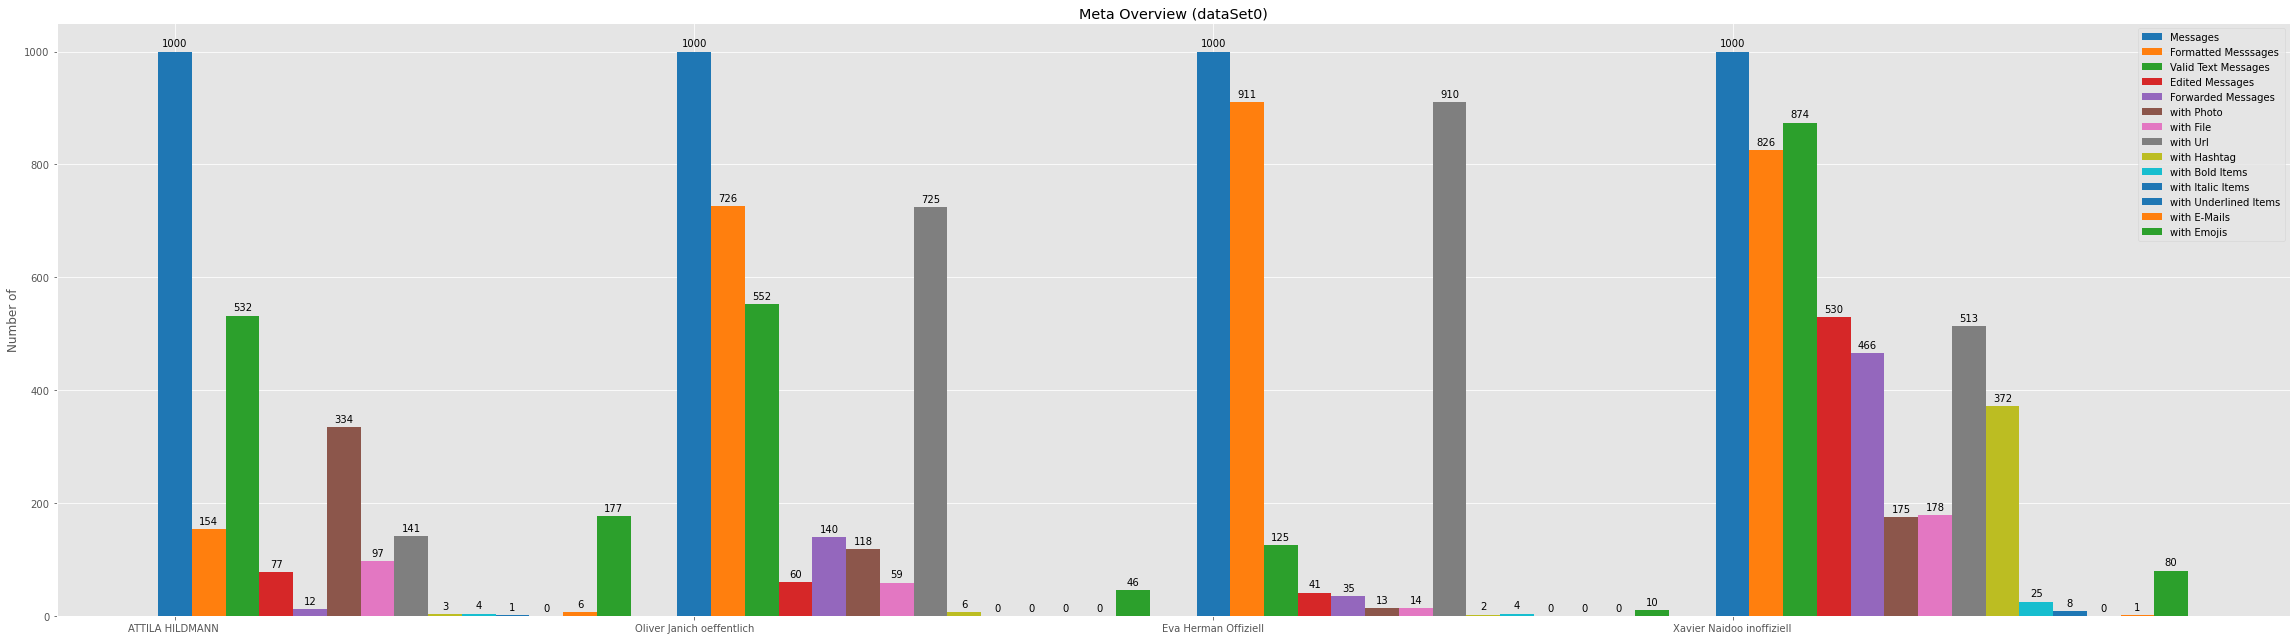

In [45]:
queryMetaPlotter(
    inputDescFilter = "dataSet0",
    configPlotWidth = 32,
    configPlotHeight = 9,
    configBarWidth = 0.065,
    outputFilename = "meta-overview-dataSet0.png"
)

In [46]:
if("dataSet1" in C_LOAD_DATASET):
    queryMetaPlotter(
        inputDescFilter = "dataSet1",
        configPlotWidth = 100,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet1.png"
    )

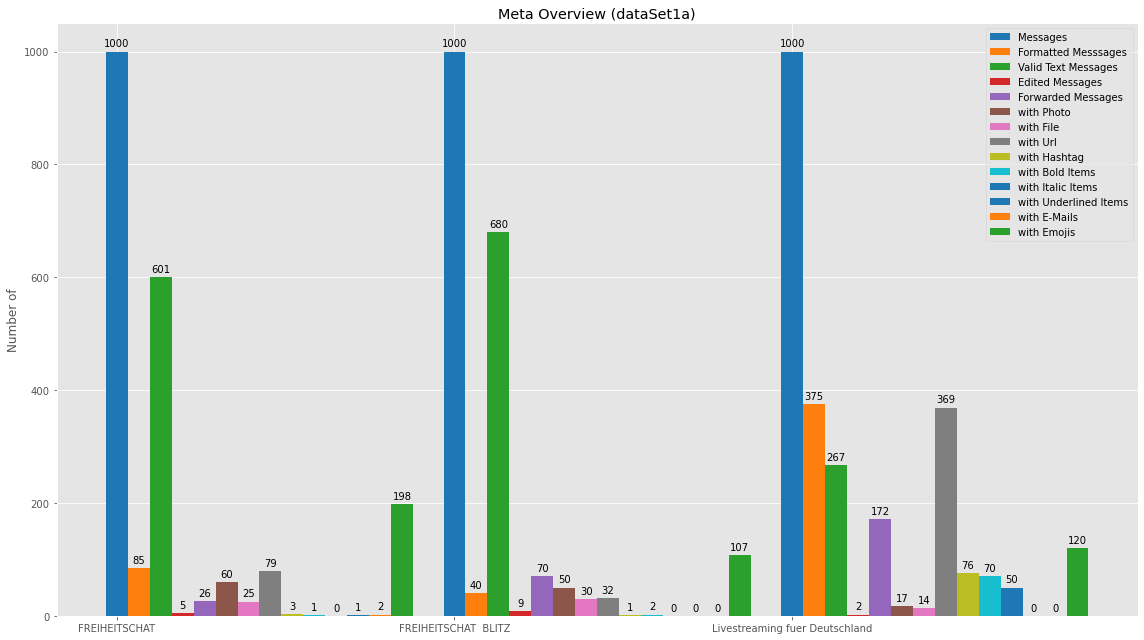

In [47]:
if("dataSet1a" in C_LOAD_DATASET):
    queryMetaPlotter(
        inputDescFilter = "dataSet1a",
        configPlotWidth = 16,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet1a.png"
    )

In [48]:
if("dataSet2" in C_LOAD_DATASET):
    queryMetaPlotter(
        inputDescFilter = "dataSet2",
        configPlotWidth = 34,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet2.png"
    )

### Get text-length

In [49]:
def removeTextLengthOutliersFromDataFrame(df, interval, maxTextLength):
    df = df.copy()
    df = df[df.procTDTextLength < maxTextLength]
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within <interval> to -<interval> standard deviations in the column 'Data'.
    return df[np.abs(df.procTDTextLength-df.procTDTextLength.mean()) <= (interval*df.procTDTextLength.std())]

In [50]:
# param outputFilename set "" == no output file
def textLengthHistPlotter(outputFilename):
    dfMessages = dfAllDataMessages.copy()
    print("Number of all messages:\t\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = dfMessages[dfMessages.procEvalIsValidText == True]
    print("Number of valid text messages:\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = removeTextLengthOutliersFromDataFrame(
        dfMessages,
        interval = 3,               #Default is 3
        maxTextLength = 999999999   #TODO: Maybe enable max text length
        )
    print("Number of valid text messages (after outliers filtering):\t" + str(len(dfMessages.index)))

    print()
    print("Text Length Hist (after outliers filtering)")
    plt.figure(figsize=(8,4.5))
    _ = dfMessages.procTDTextLength.hist(bins=40)
    plt.title('Histogram Text Length')

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

Number of all messages:						7000
Number of valid text messages:					3631
Number of valid text messages (after outliers filtering):	3557

Text Length Hist (after outliers filtering)


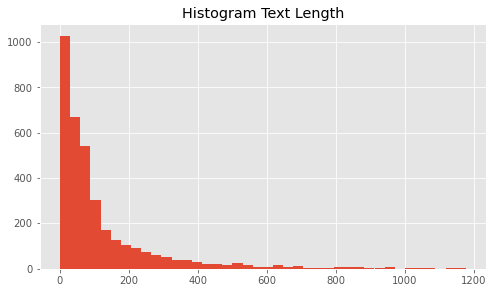

In [51]:
textLengthHistPlotter(outputFilename = "meta-text-length-hist.png")

### Compare ids and labels (has chat name changed?)

In [52]:
def compareIdsAndLabels(df):

    gloStartStopwatch("Compare ids and labels")

    dictFromTranslator  = {}
    dictActorTranslator = {}

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    df = df.set_index("date")
    df = df.sort_index()

    for index, row in df.iterrows():
        
        n_from      = row["from"]
        n_from_id   = row["from_id"]

        n_from = str(n_from)
        n_from_id = str(n_from_id)

        n_actor      = row["actor"]
        n_actor_id   = row["actor_id"]

        n_actor = str(n_actor)
        n_actor_id = str(n_actor_id)

        if(str(n_from) != "nan"):
            if(n_from_id not in dictFromTranslator):
                # Add new key
                dictFromTranslator[n_from_id] = [n_from]
            else:
                # Has changed?
                oValueL = dictFromTranslator[n_from_id]
                if(n_from not in oValueL):
                    newList = oValueL
                    newList.append(n_from)
                    print("- Add changed attribute in from (prev=" + str(oValueL) + "/new=" + str(newList) + ")")
                    dictFromTranslator[n_from_id] = newList

        if(str(n_actor) != "nan"):
            if(n_actor_id not in dictActorTranslator):
                # Add new key
                dictActorTranslator[n_actor_id] = [n_actor]
            else:
                # Has changed?
                oValueL = dictActorTranslator[n_actor_id]
                if(n_actor not in oValueL):
                    newList = oValueL
                    newList.append(n_actor)
                    print("- Add changed attribute in actor (prev=" + str(oValueL) + "/new=" + str(newList) + ")")
                    dictActorTranslator[n_actor_id] = newList

    gloStopStopwatch("Compare ids and labels")

    return dictFromTranslator

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
if(C_SHORT_RUN == False):
    compareIdsAndLabels(dfAllDataMessages)

## Extract Social Graph Data

In [54]:
def extractImportantHashtags(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsHashtag == True]

    hashTagList = list()
    for index, row in dfMessages.iterrows():
        for hashtagItem in row["procTDHashtags"]:
            hashTagList.append(hashtagItem)

    return hashTagList

In [55]:
# return combinations
def extractImportantEmojis(df):

    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsEmojiItem == True]

    li = dfMessages.procTDEmojisDesc.values.tolist()

    retLi = list()

    for l in li:
        aString = ""
        for e in l:
            aString = aString + ":" + e 
        retLi.append(aString)

    return retLi

In [56]:
# param flagResolveNewUrls  Flag (see config above)
def resolveUrl(completeUrl, flagResolveNewUrls):
    
    if "bit.ly" in completeUrl:

        if(gloCheckIsAlreadyCached("resolved-urls.csv", completeUrl)):
            return gloGetCached("resolved-urls.csv", completeUrl)
        else:

            if(flagResolveNewUrls == False):
                print("(Disable resolve new urls (return completeUrl) >>" + completeUrl + "<<)")
                return completeUrl

            print("(Resolve now >>" + completeUrl + "<<)")
            try:
                r = requests.get(completeUrl, timeout = 5)
                u = r.url
                gloAddToCache("resolved-urls.csv", completeUrl, u)
                return u
            except:
                print("(- Warn: Can not resolve (return completeUrl))")
                return completeUrl

    else:
        return completeUrl

In [57]:
# Return
# a = urlList,
# b = refList
# c = hostList
def extractImportantUrls(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsUrl == True]

    hostList        = list()
    urList          = list()
    refList         = list()

    counterSucHostname = 0
    counterErrHostname = 0

    for index, row in dfMessages.iterrows():
        for urlItem in row["procTDURLs"]:
            
            urlData = urlparse(str(urlItem))

            completeUrl      = urlData.geturl()

            rUrl     = resolveUrl(completeUrl, flagResolveNewUrls=C_RESOLVE_NEW_URLS)
            rUrlData = urlparse(rUrl)
            rCompleteUrl = rUrlData.geturl()
            rCompleteHostname = rUrlData.hostname

            if(str(rCompleteHostname) != "None"):
                counterSucHostname = counterSucHostname + 1

                hostList.append(str(rCompleteHostname))

                urList.append(str(rCompleteUrl))

                if "t.me" in str(rCompleteHostname):
                    refList.append(str(rCompleteUrl))
            else:
                counterErrHostname = counterErrHostname + 1

    print("Got Hostnames (suc=" + str(counterSucHostname) + "/err=" + str(counterErrHostname) + ")")

    return (urList, refList, hostList)

In [58]:
# param flagResolveNewUrls  Flag (see config above)
def resolveImportantYoutubeVideos(urlList, flagResolveNewUrls):

    # Thanks https://gist.github.com/rodrigoborgesdeoliveira/987683cfbfcc8d800192da1e73adc486

    ytList = list()

    for url in urlList:

        url = str(url)

        if("youtube.com" in url or "youtu.be" in url or "youtube-nocookie.com" in url):
            if(gloCheckIsAlreadyCached("resolved-youtube.csv", url)):
                ytList.append(gloGetCached("resolved-youtube.csv", url)) 
            else:

                if(flagResolveNewUrls == False):
                    print("(Disable resolve new youtube urls (return completeUrl) >>" + url + "<<)")
                    ytList.append(url)
                else:
                    print("Resolve now youtube >>" + url + "<<")
                    try:
                        r = requests.get(url, timeout = 5)
                        t = fromstring(r.content)
                        a = str(t.findtext('.//title'))
                        ytList.append(a)
                        gloAddToCache("resolved-youtube.csv", url, a)
                    except:
                        print("(- Warn: Can not resolve youtube url (return completeUrl))")
                        ytList.append(url)

    return ytList

In [59]:
# TODO: Bug: No Hostname detected if string startsWith ! "http" in urlparse
# TODO: Check: Refs ins both directions

# Returns
# a = Counter forwardedFromList
# b = Counter refList
# c = Counter hashtagList
# d = Counter hostList
# e = Counter emojiList
# f = Counter fromList
def extractSocialGraph(filePath, debugPrint, debugPrintCount):

    dfMessages = dictMessages[filePath].copy()

    hashtagList = extractImportantHashtags(dfMessages)
    emojiList = extractImportantEmojis(dfMessages)

    urlList, refList, hostList = extractImportantUrls(dfMessages)

    ytList = resolveImportantYoutubeVideos(urlList, flagResolveNewUrls = C_RESOLVE_NEW_URLS)
            
    forwardedFromList = list()
    if("forwarded_from" in dfMessages.columns):
        df = dfMessages.copy()
        df = df[df.procEvalIsForwarded == True]
    
        for index, row in df.iterrows():        
            forwardedFromList.append(str(row["forwarded_from"]))
            
    actorList = list()
    if("actor" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            actorList.append(str(row["actor"]))
    
    memberList = list()
    if("members" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            if(str(row["members"]) != "nan"):
                for memberItem in row["members"]:
                    memberList.append(str(memberItem))
                    
    fromList = list()
    if("from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            s = str(row["from"])
            s = gloConvertToSafeString(s)
            fromList.append(s)
            
    savedFromList = list()
    if("saved_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            savedFromList.append(str(row["saved_from"]))

    configTopN = debugPrintCount

    if(debugPrint):

        print()
        print("Set top n to " + str(debugPrintCount))
        print()

        print("- Top Hosts (resovled) -")
        print ("\n".join(map(str, Counter(hostList).most_common(configTopN))))
        print()
        print("- Top URLs (resolved) -")
        print ("\n".join(map(str, Counter(urlList).most_common(configTopN))))
        print()
        print("- Top Refs from text (resolved) -")
        print ("\n".join(map(str, Counter(refList).most_common(configTopN))))
        print()
        print("- Top Refs (forwarded_from) -")
        print ("\n".join(map(str, Counter(forwardedFromList).most_common(configTopN))))
        print()
        print("- Top Refs (actor) -")
        print ("\n".join(map(str, Counter(actorList).most_common(configTopN))))
        print()
        print("- Top Refs (members) -")
        print ("\n".join(map(str, Counter(memberList).most_common(configTopN))))
        print()
        print("- Top Refs (from) -")
        print ("\n".join(map(str, Counter(fromList).most_common(configTopN))))
        print()
        print("- Top Refs (saved_from) -")
        print ("\n".join(map(str, Counter(savedFromList).most_common(configTopN))))
        print()
        print("- Top hashtags -")
        print ("\n".join(map(str, Counter(hashtagList).most_common(configTopN))))
        print()
        print("- Top emojis -")
        print ("\n".join(map(str, Counter(emojiList).most_common(configTopN))))
        print()
        print("- Top yt -")
        print ("\n".join(map(str, Counter(ytList).most_common(configTopN))))
        print()
    
    return (Counter(forwardedFromList), Counter(refList), Counter(hashtagList),  Counter(hostList), Counter(emojiList), Counter(fromList))

In [60]:
dictSGD_ForwardedFrom = {}
dictSGD_Ref           = {}
dictSGD_Hashtag       = {}
dictSGD_Host          = {}
dictSGD_Emoji         = {}
dictSGD_From          = {}

gloStartStopwatch("Extract Social Graph Data")

for fP in dfInputFiles.inputPath:

    gloStartStopwatch("Extract Social Graph Data >>" + fP + "<<")

    a, b, c, d, e, f = extractSocialGraph(fP, debugPrint=False, debugPrintCount = 0)

    dictSGD_ForwardedFrom[fP]   = a
    dictSGD_Ref[fP]             = b
    dictSGD_Hashtag[fP]         = c
    dictSGD_Host[fP]            = d
    dictSGD_Emoji[fP]           = e
    dictSGD_From[fP]            = f

    gloStopStopwatch("Extract Social Graph Data >>" + fP + "<<")

gloStopStopwatch("Extract Social Graph Data")

[Stopwatch started >>Extract Social Graph Data<<]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
Got Hostnames (suc=134/err=10)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (0.440s)]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
Got Hostnames (suc=788/err=12)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (0.361s)]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
Got Hostnames (suc=917/err=1)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (0.353s)]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
Got Hostnames (suc=556/err=41)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (0.486s)]
[Stop

In [61]:
def printSocialGraphDebug(filePathList):
    for fP in filePathList:
        print("Analyse now >>" + fP + "<<")
        _ = extractSocialGraph(fP, debugPrint=True, debugPrintCount=10)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
if(C_SHORT_RUN == False):
    printSocialGraphDebug(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath)

In [63]:
if(C_SHORT_RUN == False):
    printSocialGraphDebug(dfInputFiles[dfInputFiles.inputDesc == "dataSet1a"].inputPath)

In [64]:
if(C_SHORT_RUN == False):
    printSocialGraphDebug(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath)

### Get Top Influencer (Downloaded?)

In [65]:
# Get Top Influencer
# param fPList      filePath List
# param configTopN  Get Top n influencer e.g. 10
def getTopInfluencer(fPList, configTopN):

    for fP in fPList:

        chatName = queryChatName(fP)

        print()
        print("Analyse Chat (Forwarded From) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_ForwardedFrom[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # Already downloaded?
            flagDownloaded = False
            if oChatName in dfQueryMeta.qryChatName.values:
                flagDownloaded = True

            if(oChatName != "nan"):

                print(str(counter) + ": (downloaded=" + str(flagDownloaded) + ") (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1


        print()
        print("Analyse Chat (Refs) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_Ref[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = str(oChatName)
            oChatRefs    = oChatRefs

            if(oChatName != "nan"):

                print(str(counter) + " (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1

In [66]:
# TODO: Can not get all items in dataSet1

"""
# Attila Hildmann #
- Anonymous Germany - not found
- https://t.me/DEMOKRATENCHAT - no entries
- https://t.me/ChatDerFreiheit - no entries
- https://t.me/FREIHEITSCHAT2020 - not found

# Oliver Janich #
- Oliver Janich Premium - not found

# Xavier Naidoo #
- Xavier(Der VereiNiger)Naidoo😎 - not found
- https://t.me/PostAppender_bot - bot chat
"""
getTopInfluencer(list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath), 10)


Analyse Chat (Forwarded From) >>ATTILA HILDMANN <<
1: (downloaded=True) (refs=7)		>>ATTILA HILDMANN <<
2: (downloaded=False) (refs=2)		>>Fakten Frieden Freiheit<<
3: (downloaded=False) (refs=1)		>>Mvrco381<<
4: (downloaded=False) (refs=1)		>>WOLF<<
5: (downloaded=True) (refs=1)		>>Eva Herman Offiziell<<

Analyse Chat (Refs) >>ATTILA HILDMANN <<
1 (refs=4)		>>https://t.me/joinchat/AAAAAFYVL39T3t1H_r06qg<<
2 (refs=3)		>>https://t.me/ATTILAHILDMANN<<
3 (refs=1)		>>https://t.me/ATTILAHILDMANN/153<<
4 (refs=1)		>>https://t.me/ATTILAHILDMANN/155<<
5 (refs=1)		>>https://t.me/ATTILAHILDMANN/156<<
6 (refs=1)		>>https://t.me/FaktenFriedenFreiheit<<
7 (refs=1)		>>https://t.me/kenjebsen<<

Analyse Chat (Forwarded From) >>Oliver Janich oeffentlich<<
1: (downloaded=False) (refs=101)		>>Jouwatch<<
2: (downloaded=False) (refs=17)		>>Martin Sellner TELEGRAMELITE<<
3: (downloaded=False) (refs=9)		>>Europaeischer Remigrationspakt<<
4: (downloaded=False) (refs=6)		>>QlobalChange <<
5: (downloaded=False) 

### Plot Social Graph

In [67]:
"""
Social Graph Layout Selector

param G Graph
param layoutSelector:

1 = Kamda Kawai Layout
2 = Spring Layout
3 = Graphviz Layout
"""
def getSocialGraphLayout(layoutSelector, G):
    if(layoutSelector == 1):
        return nx.kamada_kawai_layout(G.to_undirected())
    elif(layoutSelector == 2):
        return nx.spring_layout(G.to_undirected(), k = 0.15, iterations=200)
    elif(layoutSelector == 3):
        return nx.nx_pydot.graphviz_layout(G)

In [68]:
# TODO: Try different arrows (see below): https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.ArrowStyle.html
# TODO: Check distances between nodes

"""
Draw social grah

param   G                           graph
param   layoutSelector              see above
param   configFactorEdge            e.g. 100 => weight / 100
param   configFactorNode            e.g. 10  => weight / 10
param   configArrowSize             e.g. 5
param   configPlotWidth             e.g. 16
param   configPlotHeight            e.g. 9
param   outputFilename              e.g. test.png (set "" == no output file)
param   outputTitle                 e.g. Graph (required)
"""
def drawSocialGraph(G, layoutSelector, configFactorEdge, configFactorNode, configArrowSize, configPlotWidth, configPlotHeight, outputFilename, outputTitle):
    
    gloStartStopwatch("Social Graph Plot")
    
    plt.figure(figsize=(configPlotWidth,configPlotHeight))
        
    pos = getSocialGraphLayout(layoutSelector = layoutSelector, G = G)
    
    # Clean edges
    edges       = nx.get_edge_attributes(G, "weight")
    edgesTLabel = nx.get_edge_attributes(G, "tLabel")

    clean_edges         = dict()
    clean_edges_labels  = dict()
    
    for key in edges:
        
        #Set edge weight
        clean_edges[key]        = (100 - edges[key]) / configFactorEdge

        #set edge layout
        clean_edges_labels[key] = edgesTLabel[key]
    
    # Clean nodes
    nodes       = nx.get_node_attributes(G,'weight')
    nodesTLabel = nx.get_node_attributes(G,'tLabel')
    nodesTColor = nx.get_node_attributes(G,'tColor')

    clean_nodes         = dict()
    clean_nodes_labels  = dict()
    clean_nodes_color   = dict()
    
    for key in nodes:
        
        #Set node weight        
        clean_nodes[key]        = nodes[key] / configFactorNode

        #Set node layout
        clean_nodes_labels[key] = nodesTLabel[key]
        clean_nodes_color[key]  = nodesTColor[key]
    
    # Revert DiGraph (arrows direction)
    G_rev = nx.DiGraph.reverse(G)    

    # Draw
    nx.draw(G_rev,
        pos,
        with_labels=True,
        width=list(clean_edges.values()),
        node_size=list(clean_nodes.values()),
        labels=clean_nodes_labels,
        node_color=list(clean_nodes_color.values()),
        arrowsize=configArrowSize,
        arrowstyle="wedge"
        #connectionstyle="arc3, rad = 0.1"
    )
    
    # Set labels
    _ = nx.draw_networkx_edge_labels(G_rev, pos, edge_labels=clean_edges_labels)

    plt.title(outputTitle)

    # Save and show fig
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()
    
    gloStopStopwatch("Social Graph Plot")

In [69]:
# Generates Test Graph
def generateTestGraph():

    G_weighted = nx.DiGraph()

    G_weighted.add_edge("N1", "N2", weight=100-30,  tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N1", "N3", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")
    G_weighted.add_edge("N1", "N4", weight=100-60,  tLabel = "(≙" + str(100-60) + ")")

    G_weighted.add_edge("N4", "N5", weight=100-80,  tLabel = "(≙" + str(100-80) + ")")
    G_weighted.add_edge("N4", "N6", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")

    G_weighted.add_edge("N4", "N7", weight=100-30,   tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N7", "N4", weight=100-70,   tLabel = "(≙" + str(100-70) + ")")

    G_weighted.add_node("N1", weight=500.0, tLabel = "N1-T", tColor="red")
    G_weighted.add_node("N2", weight=500.0, tLabel = "N2-T", tColor="blue")
    G_weighted.add_node("N3", weight=500.0, tLabel = "N3-T", tColor="blue")
    G_weighted.add_node("N4", weight=500.0, tLabel = "N4-T", tColor="red")
    G_weighted.add_node("N5", weight=500.0, tLabel = "N5-T", tColor="red")
    G_weighted.add_node("N6", weight=500.0, tLabel = "N6-T", tColor="red")
    G_weighted.add_node("N7", weight=500.0, tLabel = "N7-T", tColor="blue")

    return G_weighted

In [70]:
# Add node weight to dict
# Only adds new weight if newWeight > oldWeight
def addSocialGraphNodeWeight(chatName, chatWeight, targetDict):
    
    if(chatName in targetDict):
        oldWeight = targetDict[chatName]
        if(chatWeight > oldWeight):
            targetDict[chatName] = chatWeight
    else:
        targetDict[chatName] = chatWeight

In [71]:
"""
Generate social graph

param   configTopNInfluencer        e.g. For top 10 = 10
param   configMinRefs               e.g. 1 must have > 1 % forwarded messages
param   listFilePaths               List process filePaths
param   socialGraphTargetDict       e.g. forwarded from dict or hashtag dict
param   socialGraphTargetAttribute  e.g. procEvalIsForwarded (for calc percent)
param   configFlagDebugLabel        e.g. show debug info on label
"""
def generateSocialGraph(configTopNInfluencer, configMinRefs, listFilePaths, socialGraphTargetDict, socialGraphTargetAttribute, configFlagDebugLabel):
    
    # Save node weights to dict
    dictSocialNodeWeights   = dict()

    # Flag downloaded nodes (exact node weight)
    dictExactNodesLabels    = {}
    
    gloStartStopwatch("Social Graph")
    
    # Generate directed graph
    G_weighted = nx.DiGraph()
    
    print("- Add edges")
    for fP in listFilePaths:
        
        # Query own params
        chatName                        = queryChatName(fP)
        chatNumberOfMessages            = queryNumberOfMessages(fP)
        chatNumberOfTargetMessages      = queryNumberOfMessagesByAttEqTrue(fP, socialGraphTargetAttribute)

        gloStartStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
        # Add exact node size (chat downloaded) and flag node
        addSocialGraphNodeWeight(chatName, chatNumberOfMessages, dictSocialNodeWeights)
        dictExactNodesLabels[chatName] = str(chatName) + "\n=[" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + "]"

        # Extract social graph data and get top influencer
        socialGraphData = socialGraphTargetDict[fP]
        socialGraphData = socialGraphData.most_common(configTopNInfluencer)
        
        # Iterate over forwarder
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # If has forwarder
            if(oChatName != "nan"):
        
                # Calc percent (forwarded_messages)
                per = (oChatRefs/chatNumberOfTargetMessages) * 100

                # Filter unimportant forwarders
                if(per > configMinRefs):
                
                    # Add estimanted node size (chat not downloaded)
                    addSocialGraphNodeWeight(oChatName, oChatRefs, dictSocialNodeWeights)

                    # Invert percent (distance)
                    wei = 100 - per

                    # Label
                    if(configFlagDebugLabel):
                        lab = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfTargetMessages) + "≙" + str(round(wei, 3)) + ")"
                    else:
                        lab = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfTargetMessages) + ")"

                    # Add edge
                    G_weighted.add_edge(
                        chatName,
                        oChatName,
                        weight=wei,
                        tLabel = lab
                    )

        gloStopStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
    print("- Add different nodes")
    for aNode in dictSocialNodeWeights:
        
        # Query node params
        nodeName   = str(aNode)
        nodeWeight = dictSocialNodeWeights[aNode]

        # Set defaults
        tValueColor = "#ff8000"
        tLabel = str(nodeName) + "\n≈[" + str(nodeWeight) + "]"

        # Overwrite (if chat downloaded = exact weight)
        if(nodeName in dictExactNodesLabels):
            tValueColor = "#0080ff"
            tLabel = dictExactNodesLabels[nodeName]
        
        G_weighted.add_node(
            nodeName,
            weight=nodeWeight,
            tLabel = tLabel,
            tColor=tValueColor
        )
        
    gloStopStopwatch("Social Graph")
        
    return G_weighted

#### Test Graphs

In [72]:
generatedTestGraph = generateTestGraph()

[Stopwatch started >>Social Graph Plot<<]


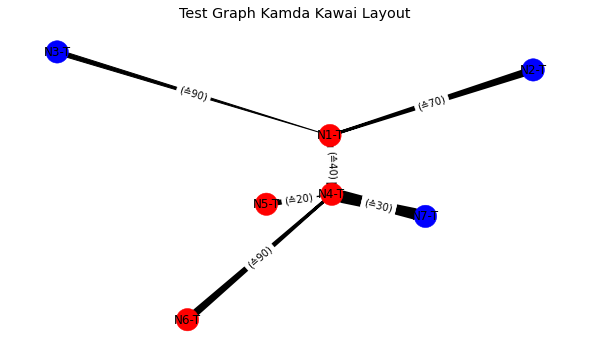

[Stopwatch stopped >>Social Graph Plot<< (0.226s)]


In [73]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=1,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = "",
    outputTitle = "Test Graph Kamda Kawai Layout"
)

[Stopwatch started >>Social Graph Plot<<]


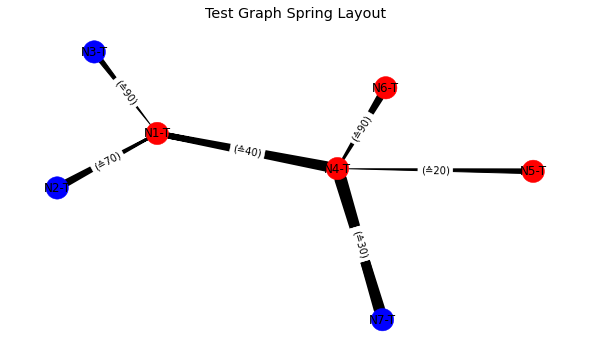

[Stopwatch stopped >>Social Graph Plot<< (0.264s)]


In [74]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=2,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = "",
    outputTitle = "Test Graph Spring Layout"
)

[Stopwatch started >>Social Graph Plot<<]


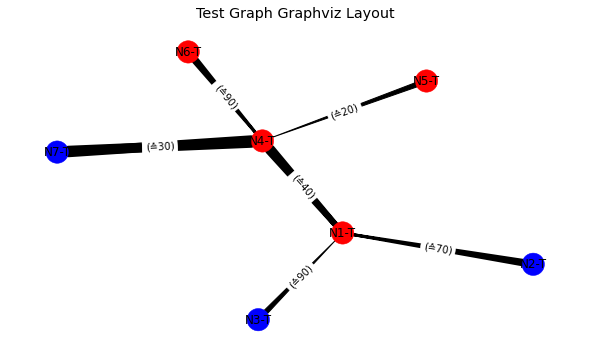

[Stopwatch stopped >>Social Graph Plot<< (0.364s)]


In [75]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=3,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = "",
    outputTitle = "Test Graph Graphviz Layout"
)

#### Real Graph (ForwardedFrom)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (12/1000 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (12/1000 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(140/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(140/1000 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(35/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(35/1000 messages)<< (0.002s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(466/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Nai

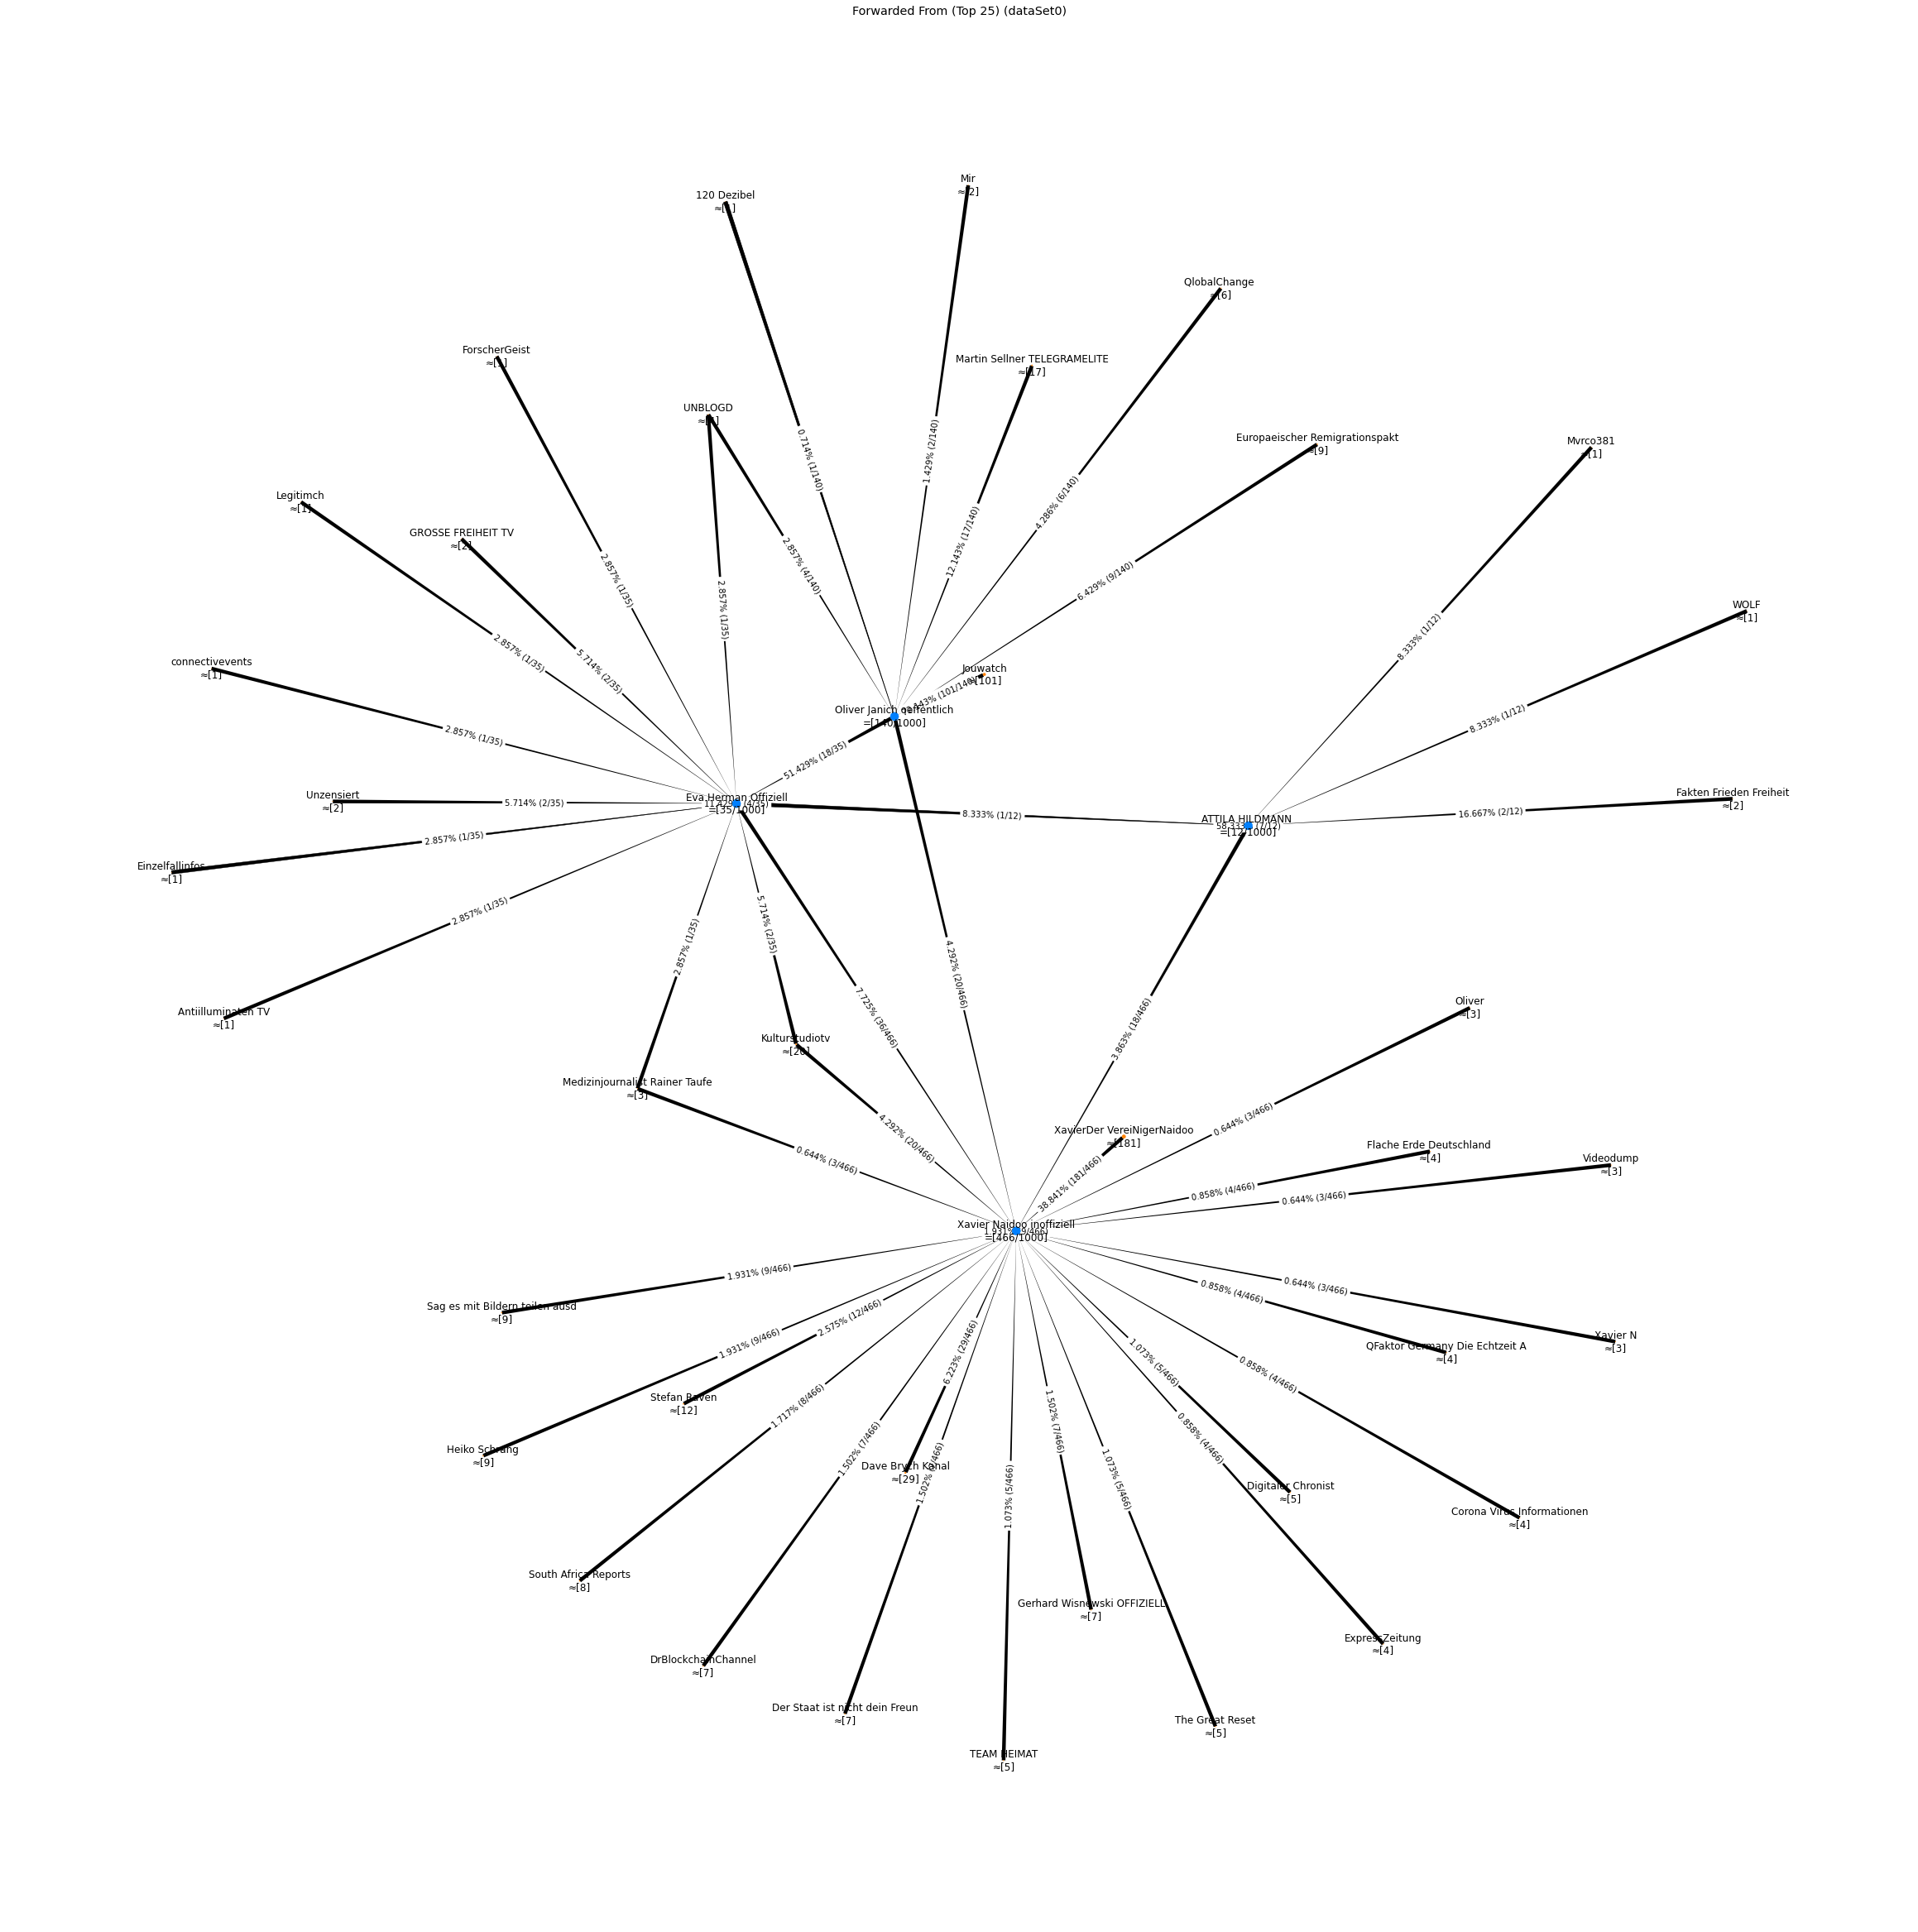

[Stopwatch stopped >>Social Graph Plot<< (2.417s)]


In [76]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,       
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_ForwardedFrom,
        socialGraphTargetAttribute = "procEvalIsForwarded",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-forwarded-from.png",
    outputTitle = "Forwarded From (Top 25) (dataSet0)"
)

In [77]:
if("dataSet2" in C_LOAD_DATASET):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 20,  
            configMinRefs = 0,       
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            socialGraphTargetDict = dictSGD_ForwardedFrom,
            socialGraphTargetAttribute = "procEvalIsForwarded",
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 10,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet2-forwarded-from.png",
        outputTitle = "Forwarded From (Top 20) (dataSet2)"
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
# TODO: Enable
"""
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,       
        listFilePaths = list(dfInputFiles.inputPath),
        socialGraphTargetDict = dictSGD_ForwardedFrom,
        socialGraphTargetAttribute = "procEvalIsForwarded",
        configFlagDebugLabel = False
    ),
    layoutSelector = 3,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-global-graphviz-forwarded-from.png",
    outputTitle = "Forwarded From (Top 25) (global - graphviz)"
)
"""

'\ndrawSocialGraph(\n    generateSocialGraph(\n        configTopNInfluencer = 25,  \n        configMinRefs = 0,       \n        listFilePaths = list(dfInputFiles.inputPath),\n        socialGraphTargetDict = dictSGD_ForwardedFrom,\n        socialGraphTargetAttribute = "procEvalIsForwarded",\n        configFlagDebugLabel = False\n    ),\n    layoutSelector = 3,\n    configFactorEdge = 100,\n    configFactorNode = 10,\n    configArrowSize = 15,\n    configPlotWidth = 32,\n    configPlotHeight = 32,\n    outputFilename = "social-graph-global-graphviz-forwarded-from.png",\n    outputTitle = "Forwarded From (Top 25) (global - graphviz)"\n)\n'

#### Real Graph (Hashtag)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (3/1000 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (3/1000 messages)<< (0.000s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(6/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(6/1000 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(2/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(2/1000 messages)<< (0.000s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(372/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo inoffiziell(372/1000 messages)<< (0.001s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.045s)]
[Stopwatch started >>Social Graph Plot<<]


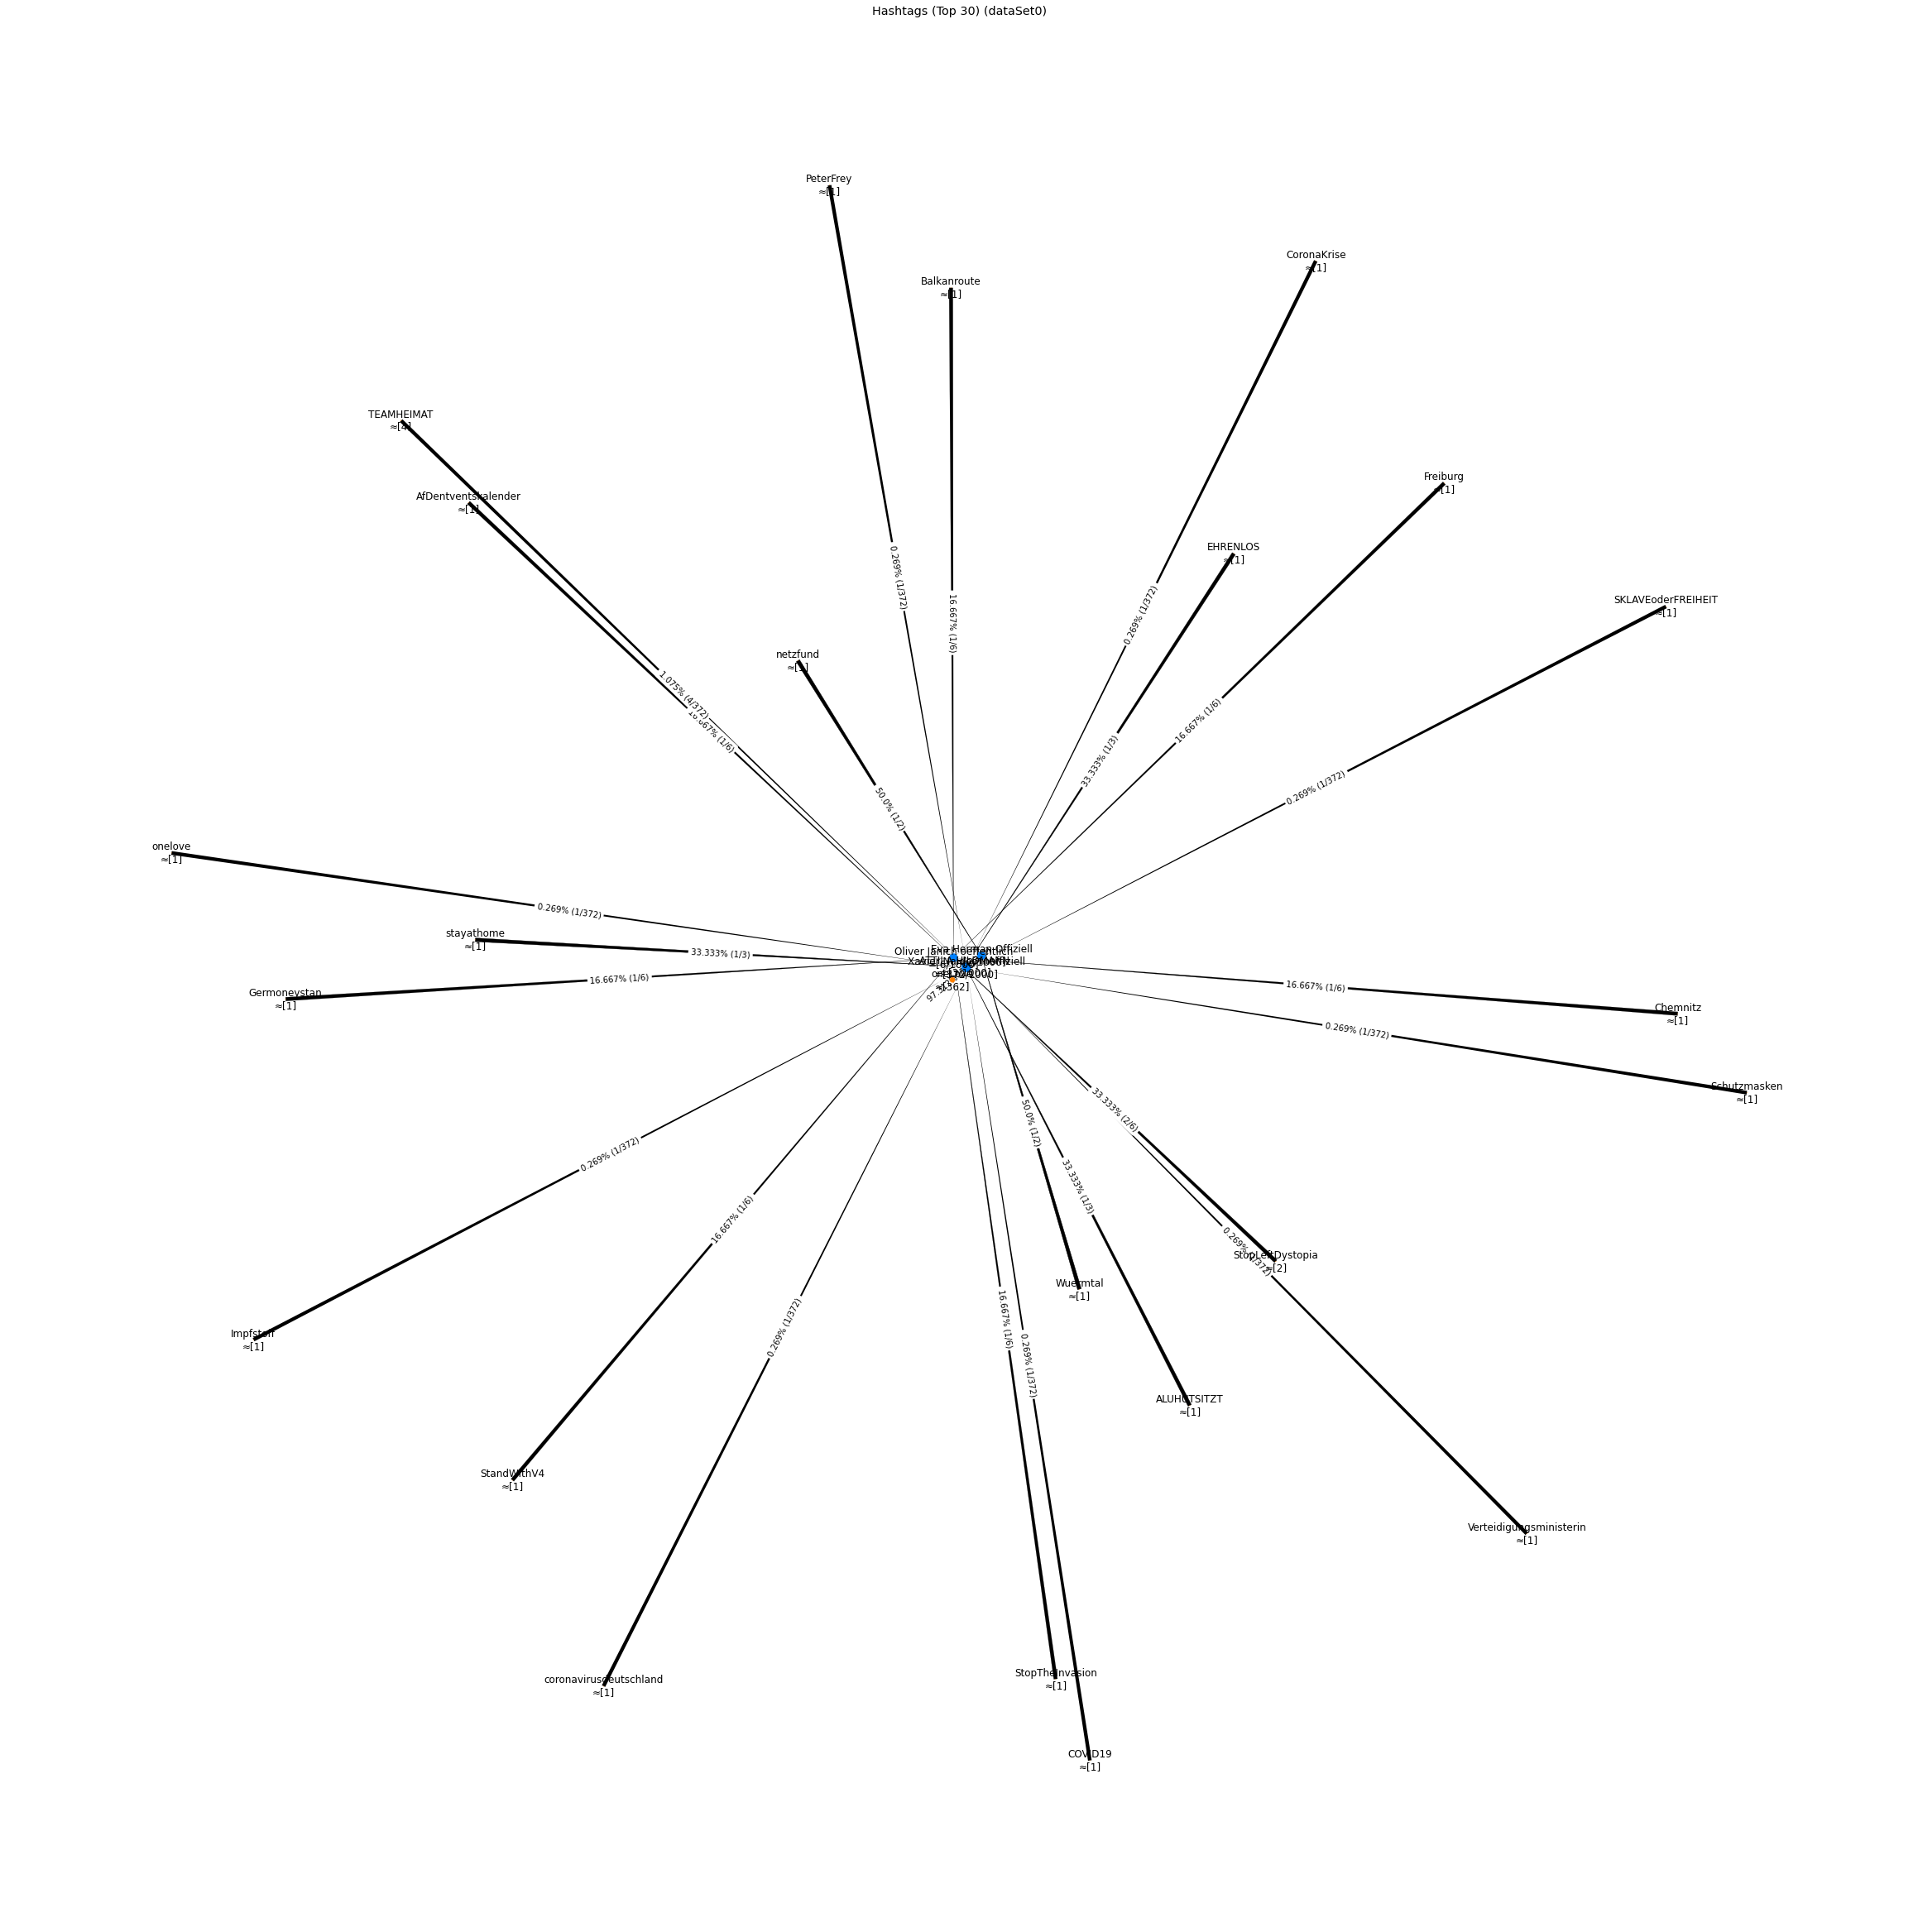

[Stopwatch stopped >>Social Graph Plot<< (1.592s)]


In [79]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 30,  
        configMinRefs = 0,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Hashtag,
        socialGraphTargetAttribute = "procEvalContainsHashtag",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-hashtag.png",
    outputTitle = "Hashtags (Top 30) (dataSet0)"
)

In [80]:
if("dataSet2" in C_LOAD_DATASET and False): #TODO: Fix Graph
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 30,  
            configMinRefs = 4,        
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            socialGraphTargetDict = dictSGD_Hashtag,
            socialGraphTargetAttribute = "procEvalContainsHashtag",
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 10,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet2-hashtag.png",
        outputTitle = "Hashtags (Top 30) (dataSet2)"
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Real Graph (Hosts)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (141/1000 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (141/1000 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(725/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(725/1000 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(910/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(910/1000 messages)<< (0.002s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(513/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo inoffiziell(513/1000 messages)<< (0.002s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.054s)]
[Stopwatch started >>Social Graph Plot<<]


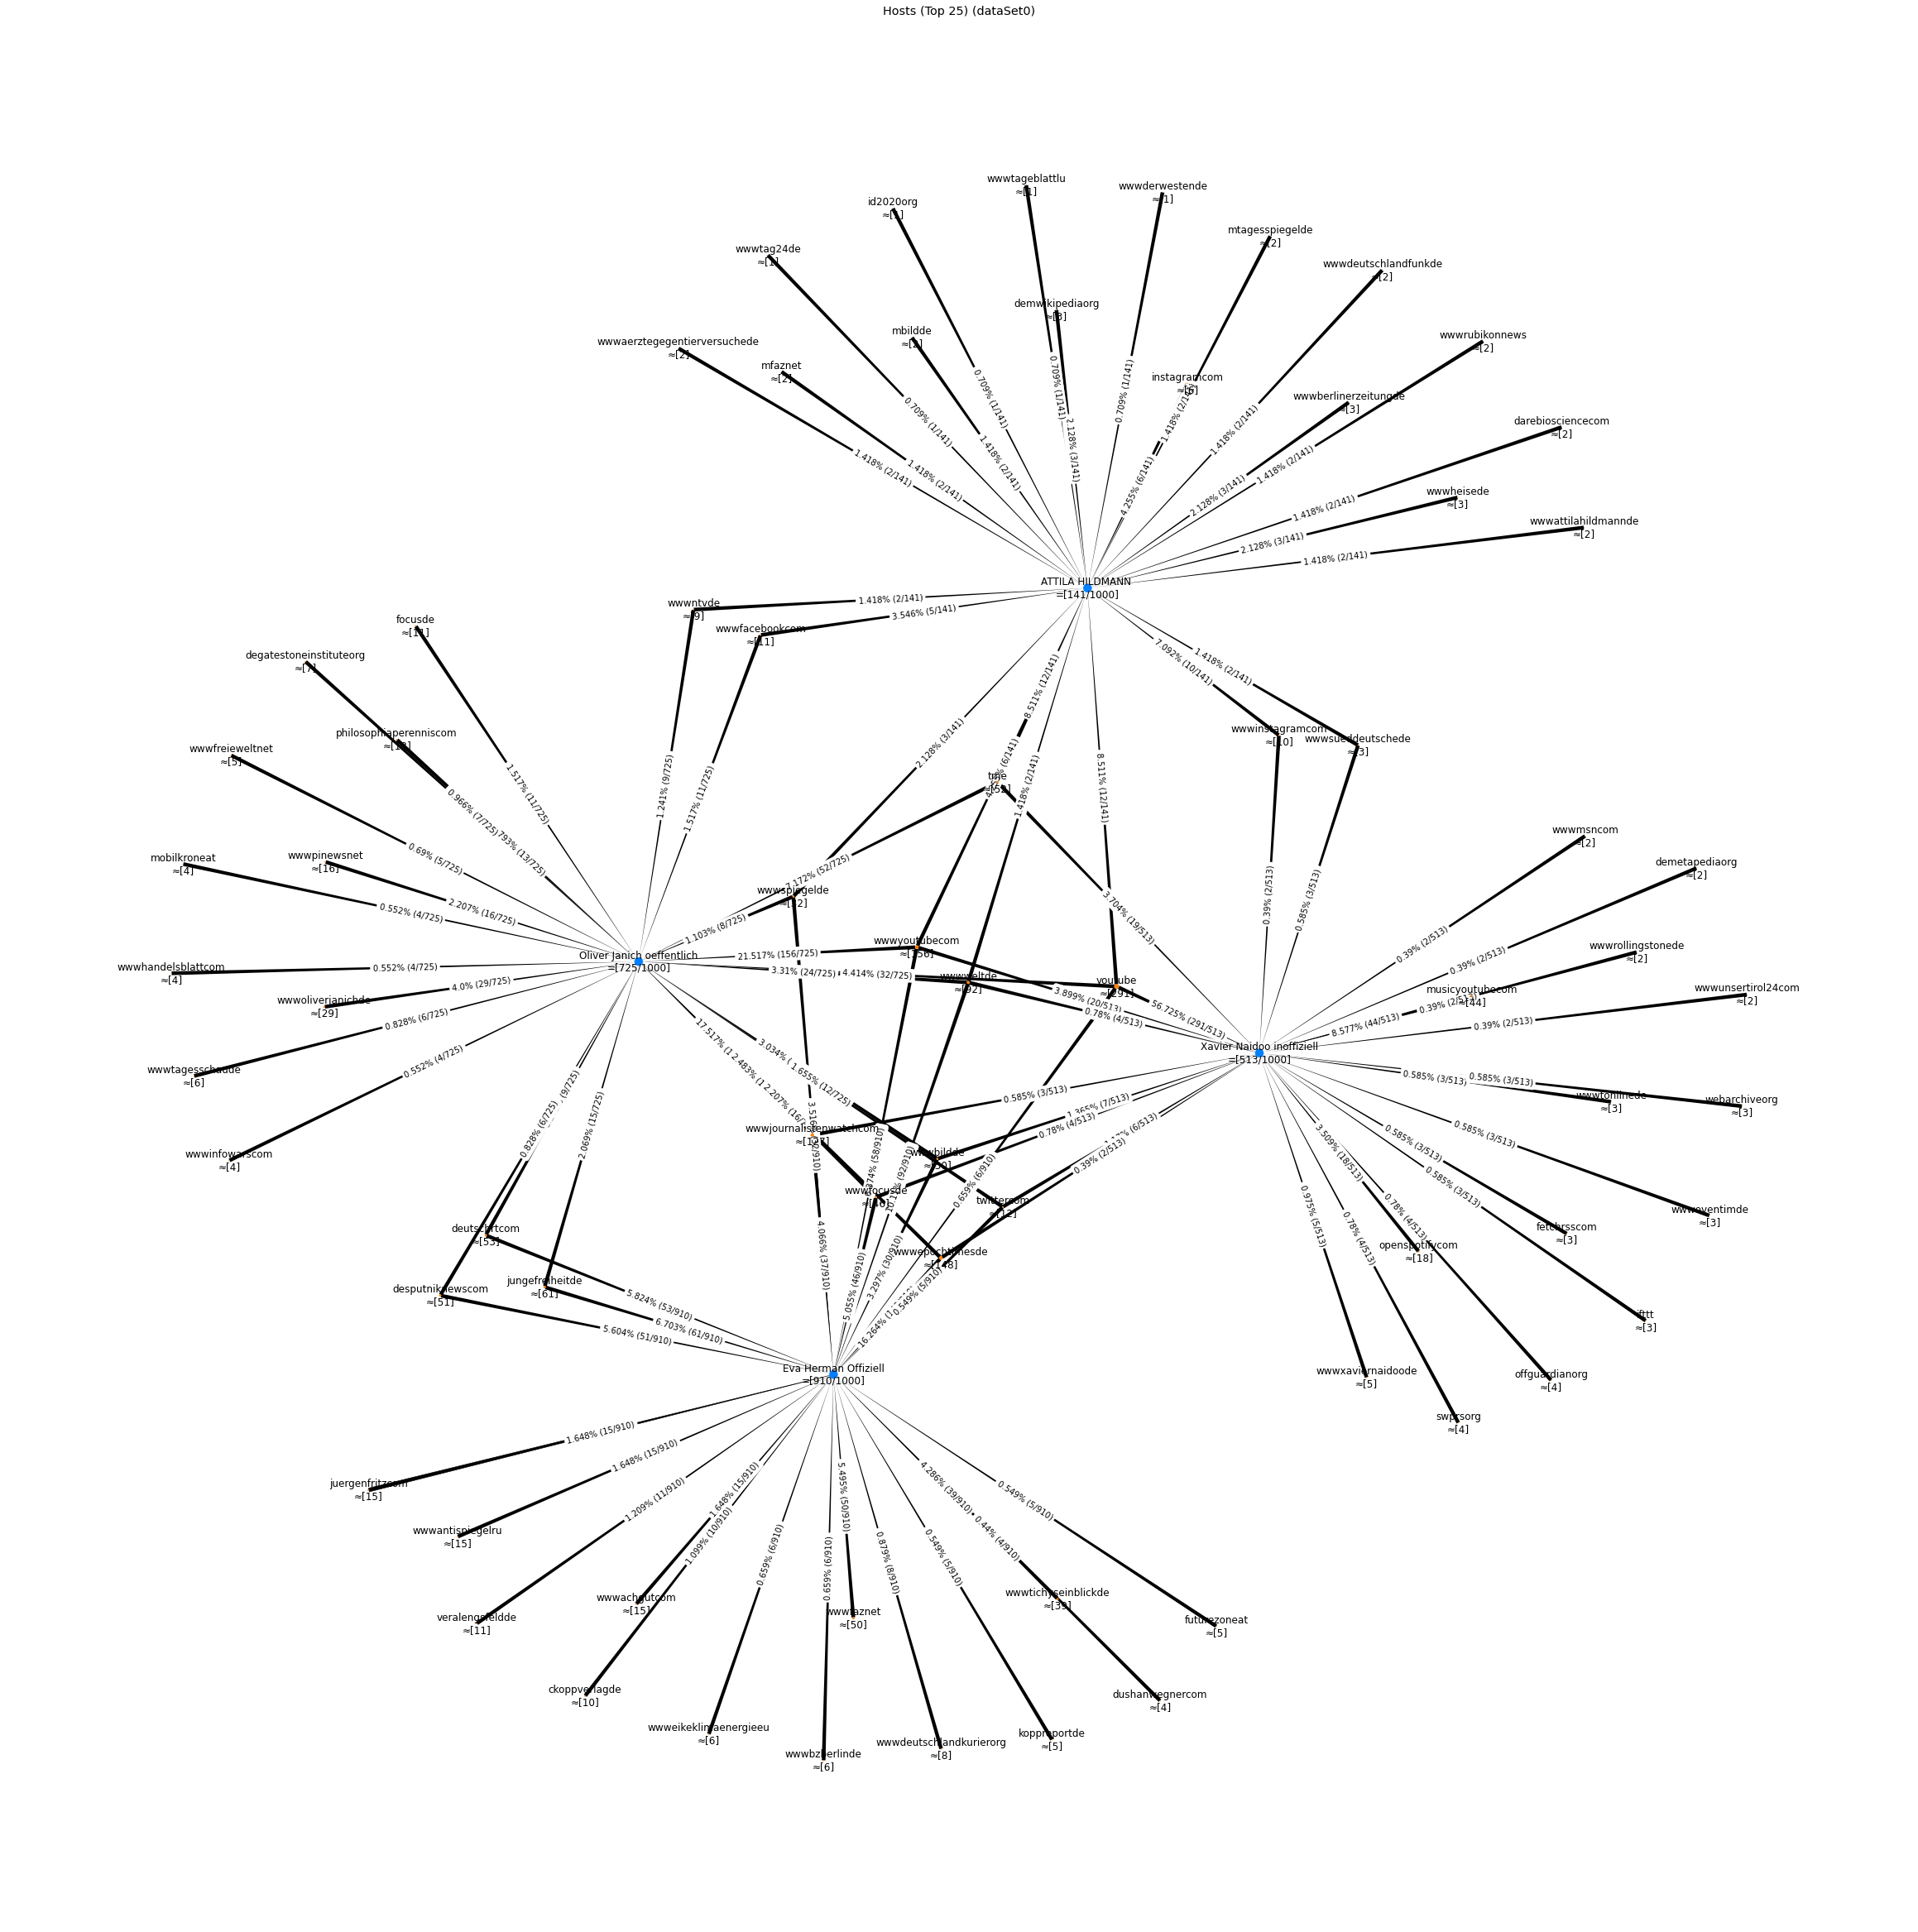

[Stopwatch stopped >>Social Graph Plot<< (5.160s)]


In [81]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Host,
        socialGraphTargetAttribute = "procEvalContainsUrl",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-host.png",
    outputTitle = "Hosts (Top 25) (dataSet0)"
)

In [82]:
if("dataSet2" in C_LOAD_DATASET):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 15,  
            configMinRefs = 0,        
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            socialGraphTargetDict = dictSGD_Host,
            socialGraphTargetAttribute = "procEvalContainsUrl",
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 10,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet2-host.png",
        outputTitle = "Hosts (Top 15) (dataSet2)"
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Real Graph (Emojis)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (177/1000 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (177/1000 messages)<< (0.004s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(46/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(46/1000 messages)<< (0.012s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(10/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(10/1000 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(80/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo inoffiziell(80/1000 messages)<< (0.008s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.064s)]
[Stopwatch started >>Social Graph Plot<<]


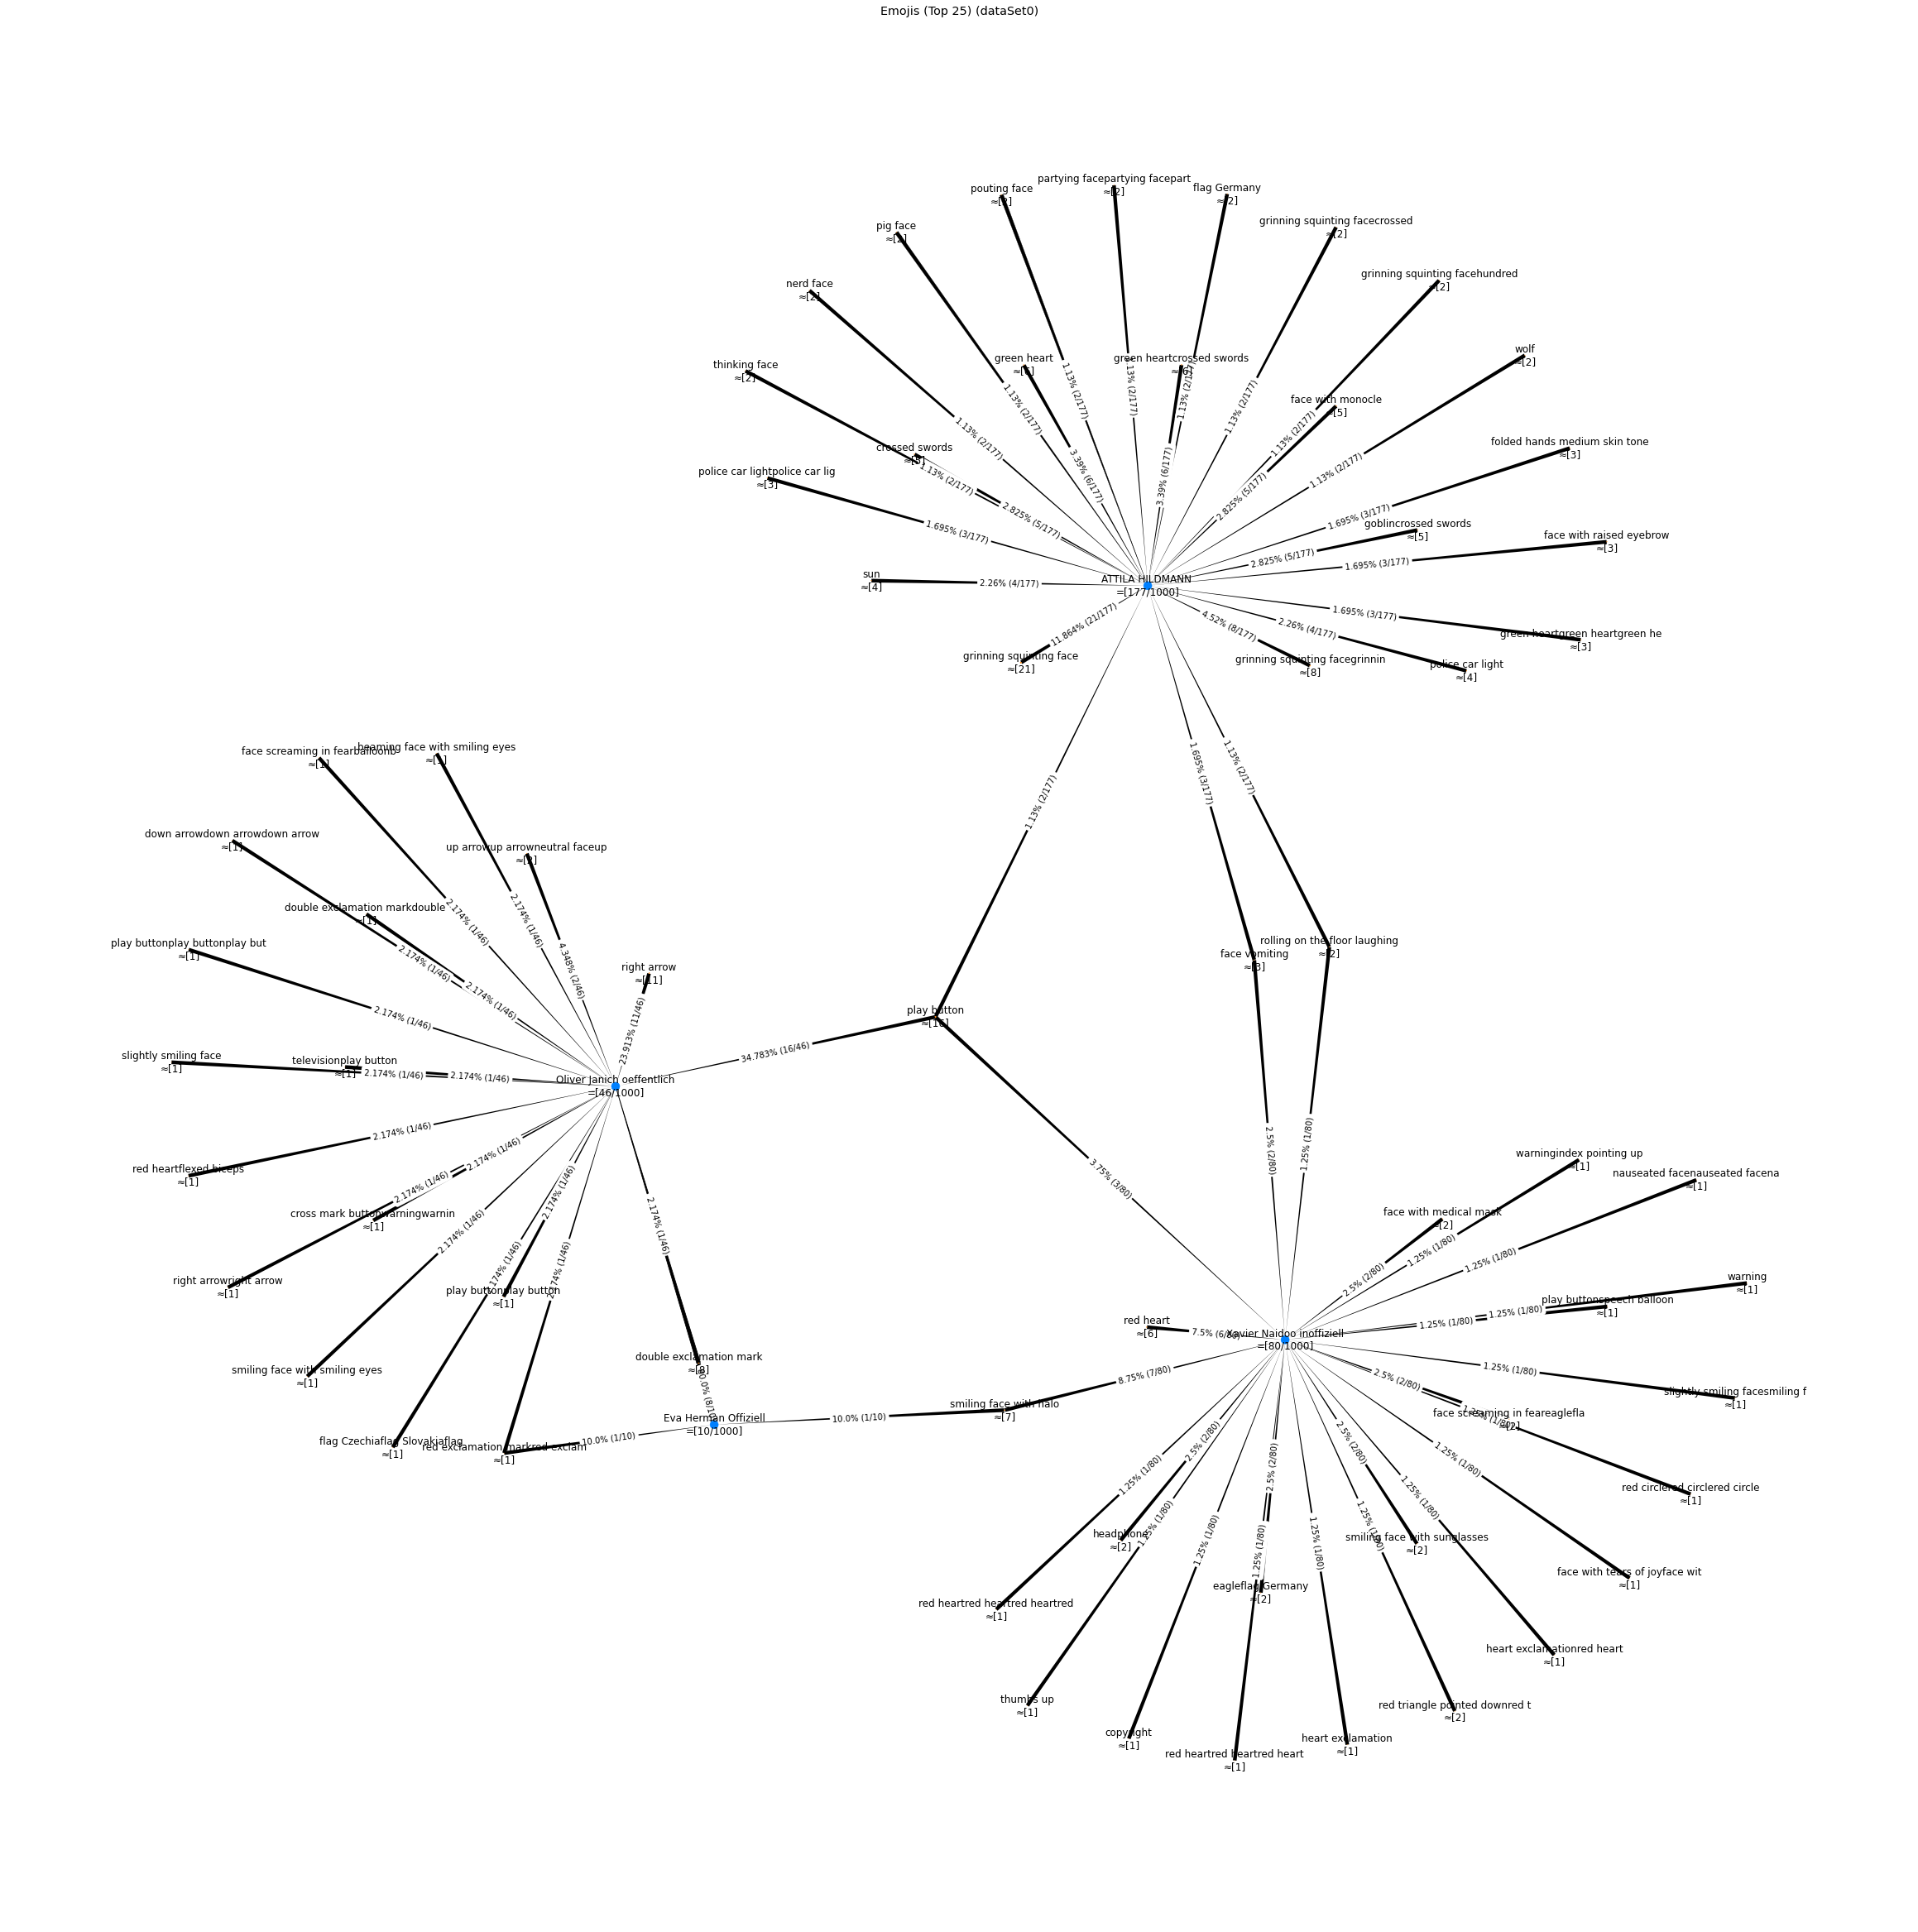

[Stopwatch stopped >>Social Graph Plot<< (4.632s)]


In [83]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Emoji,
        socialGraphTargetAttribute = "procEvalContainsEmojiItem",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-emoji.png",
    outputTitle = "Emojis (Top 25) (dataSet0)"
)

In [84]:
if("dataSet2" in C_LOAD_DATASET):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 25,  
            configMinRefs = 0,        
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            socialGraphTargetDict = dictSGD_Emoji,
            socialGraphTargetAttribute = "procEvalContainsEmojiItem",
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 10,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet2-emoji.png",
        outputTitle = "Emojis (Top 25) (dataSet2)"
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Real Graph (From)

[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract FREIHEITSCHAT(601/1000 messages)<<]
[Stopwatch stopped >>SG-Extract FREIHEITSCHAT(601/1000 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract FREIHEITSCHAT  BLITZ(680/1000 messages)<<]
[Stopwatch stopped >>SG-Extract FREIHEITSCHAT  BLITZ(680/1000 messages)<< (0.004s)]
[Stopwatch started >>SG-Extract Livestreaming fuer Deutschland(267/1000 messages)<<]
[Stopwatch stopped >>SG-Extract Livestreaming fuer Deutschland(267/1000 messages)<< (0.005s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.151s)]
[Stopwatch started >>Social Graph Plot<<]


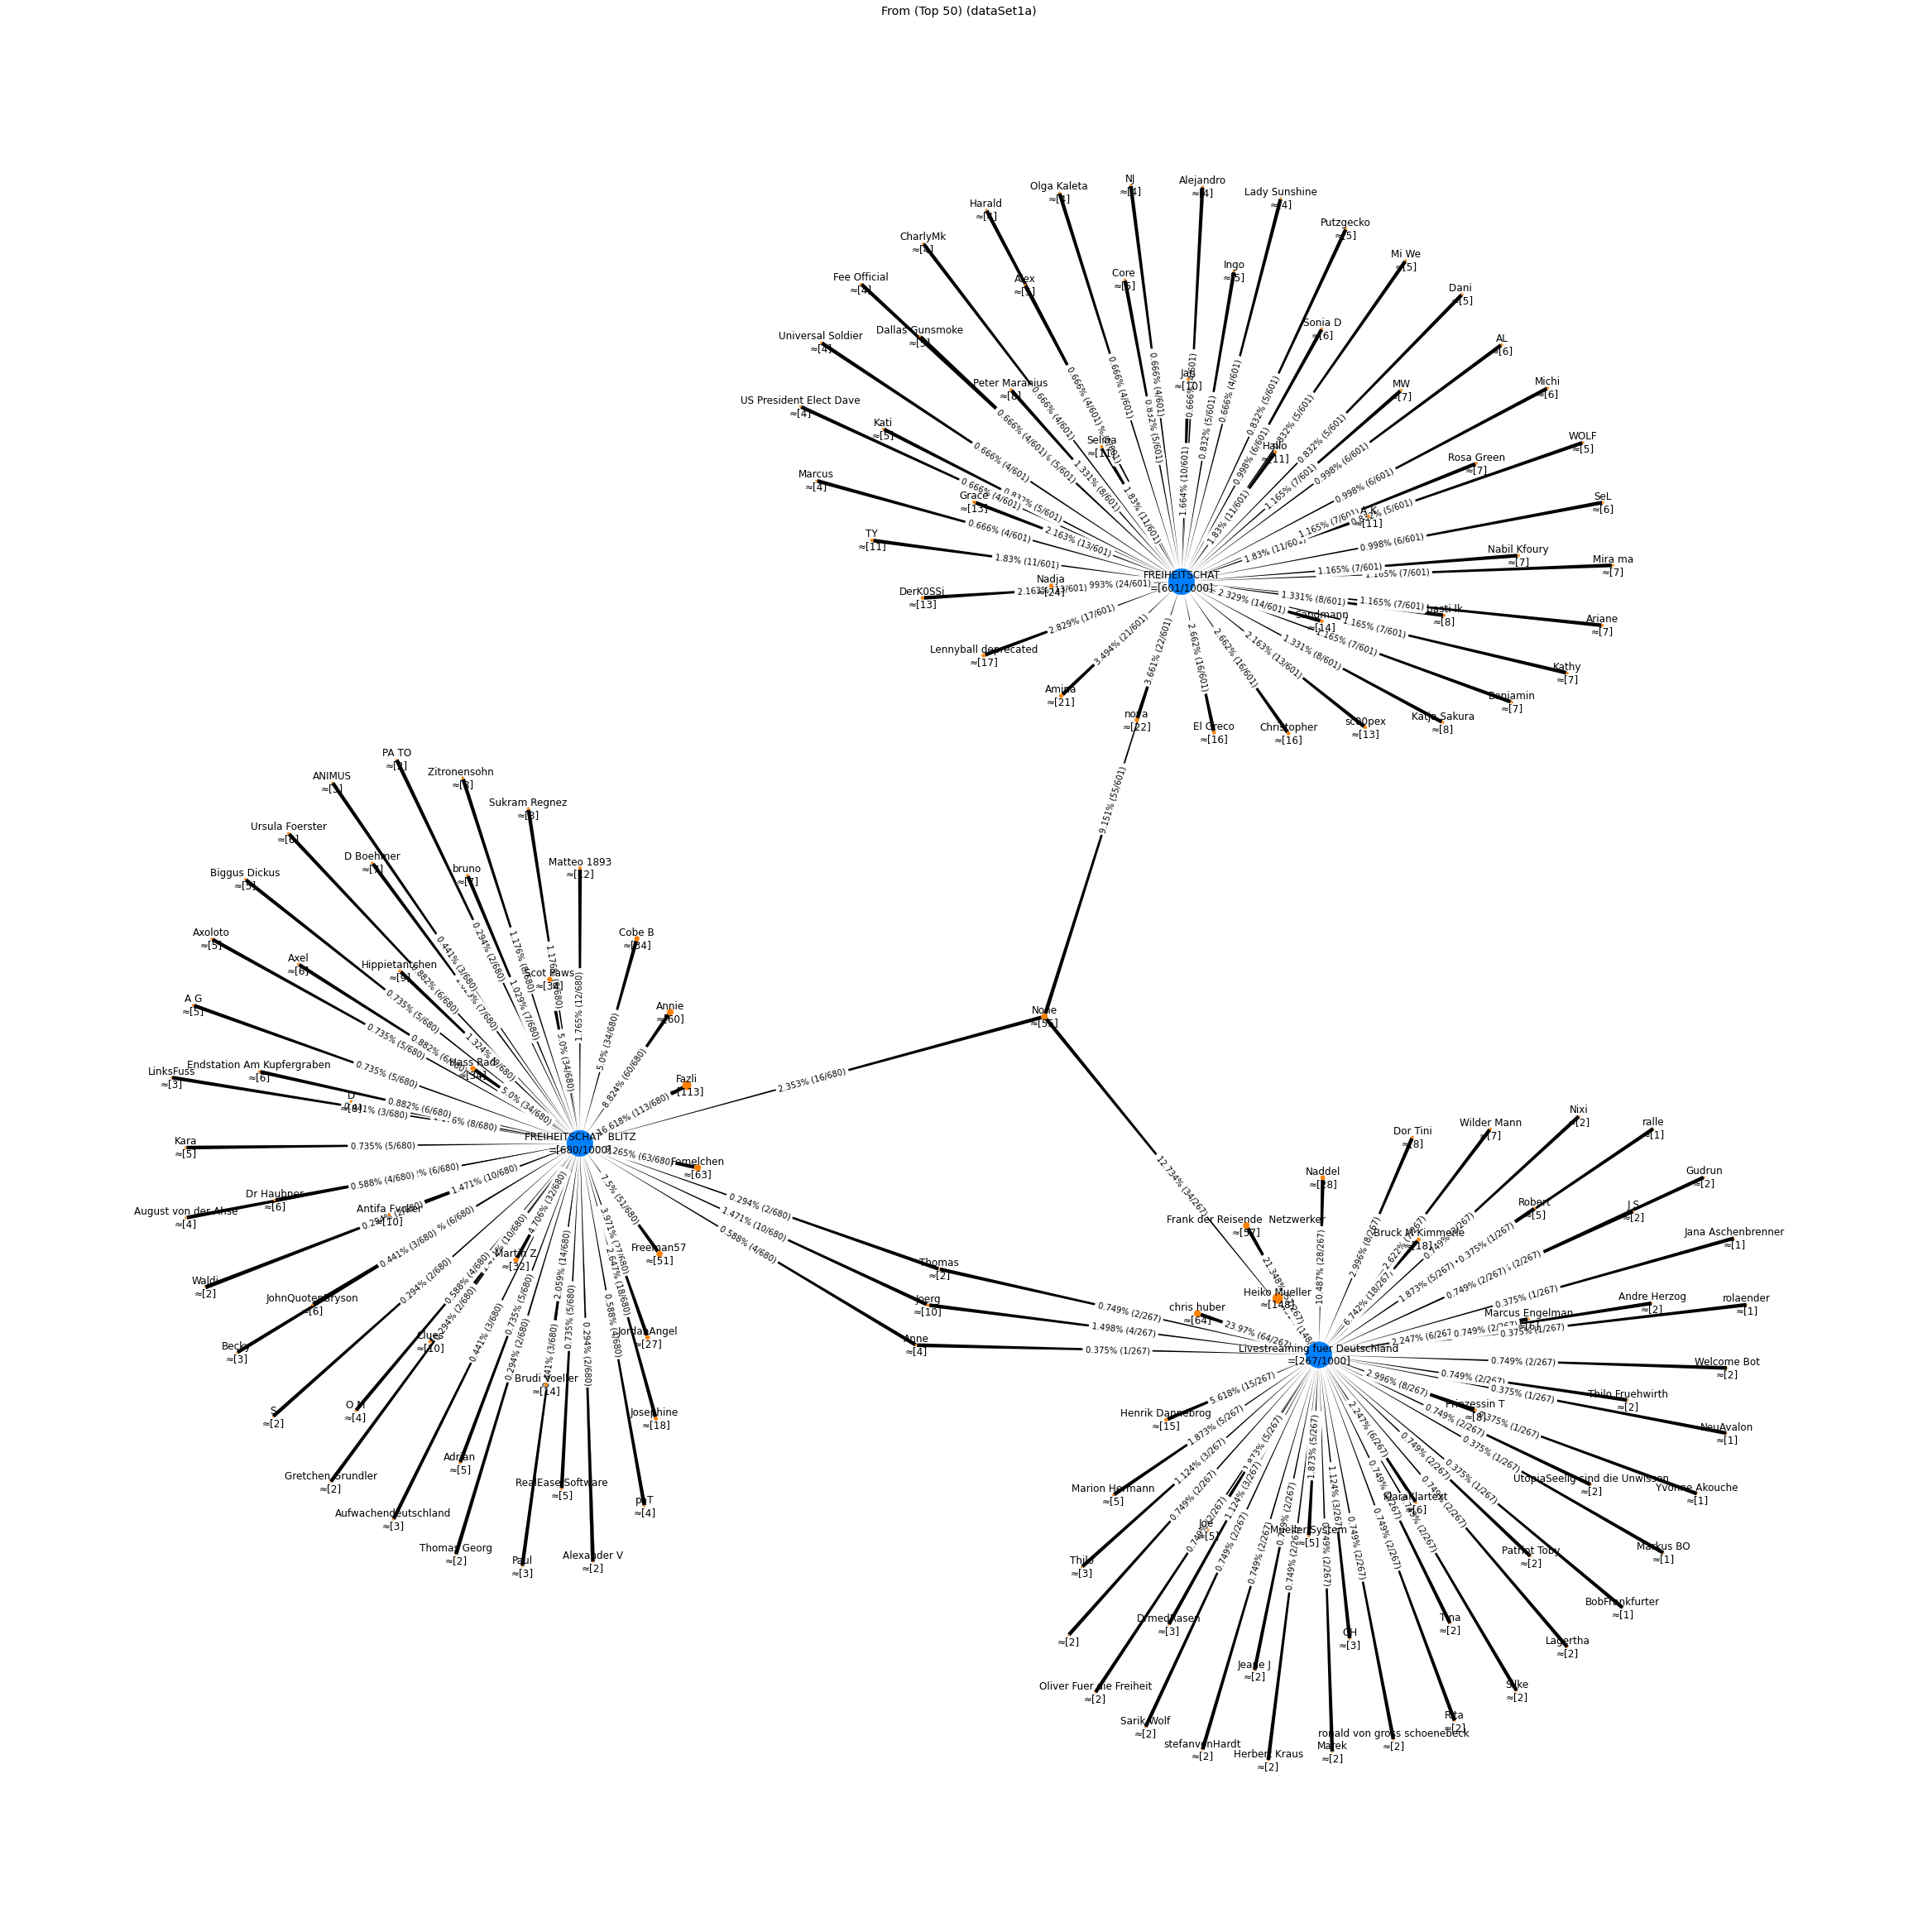

[Stopwatch stopped >>Social Graph Plot<< (9.574s)]


In [85]:
if("dataSet1a" in C_LOAD_DATASET):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 50,  
            configMinRefs = 0,        
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1a"].inputPath),
            socialGraphTargetDict = dictSGD_From,
            socialGraphTargetAttribute = "procEvalIsValidText", #TODO: Improve
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 1,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet1a-from.png",
        outputTitle = "From (Top 50) (dataSet1a)"
    )

## Time Tools

In [86]:
"""
param   targetDate      e.g. 1970-01-01
param   fP              filePath
param   highlightWord   set "" = no filter
"""
def queryNumberOfMessagesByDate(targetDate, fP, highlightWord):

    df = dictMessages[fP].copy()

    df = df[df.procEvalIsValidText == True]

    df["date"] = pd.to_datetime(df["date"])
    
    df = df[df.date <= targetDate]

    if(highlightWord != ""):
        df = df[df.procTDSafeLowercaseText.str.contains(highlightWord)]

    l = len(df.index)

    if(l > 0):
        return l
    else:
        return np.nan

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
"""
param   filePathList
param   outputFilename  set "" = no output file
param   highlightWords  list of highlight words (leave empty if not used)
param   configFrequency e.g. 1D or 1M
"""
# TODO: Add percent to label
def drawTimePlot(filePathList, outputFilename, highlightWords, configFrequency):

    gloStartStopwatch("Time Plot")

    plt.figure(figsize=(16, 9))

    df = pd.DataFrame(
        index=pd.date_range( #m/d/y
            start='9/1/2018',
            end='2/1/2021',
            freq=configFrequency
            )
        )

    # Add date to process
    df["date"] = df.index

    vLineHeight = -1

    for fP in filePathList:
        gloStartStopwatch("Time Plot >>" + fP + "<<")

        # Plot Graph Var 1
        if not highlightWords:
            # Plot
            plt.plot(
                df.index, #x
                df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = ""), axis=1), #y
                label = queryChatName(fP) #label
            )
            # Set vline height
            currentHeight = queryNumberOfMessagesByAttEqTrue(fP, "procEvalIsValidText")
            if(currentHeight > vLineHeight):
                vLineHeight = currentHeight

        # Plot High Light Word Graph / Var 2
        for hWord in highlightWords:
            y = df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = hWord), axis=1)
            # Plot
            plt.plot(
                df.index, #x
                y, #y
                label = queryChatName(fP) + " usage of '" + hWord + "'" #label
            )
            # Set vline height
            currentHeight = y.max()
            if(currentHeight > vLineHeight):
                vLineHeight = currentHeight

        gloStopStopwatch("Time Plot >>" + fP + "<<")

    # yy - mm - dd
    # TODO: Double check https://www.bundesgesundheitsministerium.de/coronavirus/chronik-coronavirus.html?stand=20210104
    plt.vlines(x = ["2018-12-10"], ymin=0, ymax=vLineHeight, color="orange", ls='--', label="Global Compact for Migration (2018-12-10)")
    plt.vlines(x = ["2020-01-27"], ymin=0, ymax=vLineHeight, color="grey", ls='--', label="Corona Patient Zero Germany")
    plt.vlines(x = ["2020-03-23"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="1. Lockdown Germany (2020-03-23)")
    plt.vlines(x = ["2020-11-02"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="2. Lockdown light Germany (2020-11-02)")
    plt.vlines(x = ["2020-12-16"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="3. Lockdown Germany (2020-12-16)")

    _ = plt.legend()

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

    gloStopStopwatch("Time Plot")

In [88]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        outputFilename = "time-plot-dataSet0.png",
        highlightWords = [],
        configFrequency=C_TIME_PLOT_FREQ
    )

In [89]:
if(C_SHORT_RUN == False):
    if("dataSet1" in C_LOAD_DATASET):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1"].inputPath),
            outputFilename = "time-plot-dataSet1.png",
            highlightWords = [],
            configFrequency=C_TIME_PLOT_FREQ
        )

In [90]:
if(C_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASET):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1a"].inputPath),
            outputFilename = "time-plot-dataSet1a.png",
            highlightWords = [],
            configFrequency=C_TIME_PLOT_FREQ
        )

In [91]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASET):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            outputFilename = "time-plot-dataSet2.png",
            highlightWords = [],
            configFrequency=C_TIME_PLOT_FREQ
        )

## Word Clouds

In [92]:
def getStopWordsList(filterList):

    stopwWorldsList = []

    deWordsList = nltk.corpus.stopwords.words('german')

    enWordsList = nltk.corpus.stopwords.words('english')

    aStopwords = []
    with open(dir_var + "additionalStopwords.txt") as file:
        for line in file: 
            line = line.strip()
            if(line != ""):
                aStopwords.append(line)

    for s in filterList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in deWordsList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in enWordsList:
        stopwWorldsList.append(s)

    for s in aStopwords:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    return stopwWorldsList

In [93]:
# TODO: Context?
# TODO: Improve stop words

"""
WordCloud

param   targetDataFrame     DataFrame
param   outputFilename      filename in outputdir (set "" == no output file)
param   filterList          Exclude list
param   flagShow            Set true == show wordcloud
param   configPlotWidth     e.g. 1920
param   configPlotHeight    e.g. 1080
"""
def generateWordCloud(targetDataFrame, outputFilename, filterList, flagShow, configPlotWidth, configPlotHeight):
    
    gloStartStopwatch("Word Cloud")

    dfMessages = targetDataFrame.copy()
    
    print("- Start transform text to global text string")
    textString = gloGenerateTextFromChat(dfMessages, rowID="procTDSafeText")
    
    stopWordsList = getStopWordsList(filterList)
    
    # Generate word cloud and save it to file
    print("- Start generate cloud")
    wordcloud = WordCloud(
                background_color="black",
                width=configPlotWidth,
                height=configPlotHeight,
                stopwords=stopWordsList
            ).generate(textString)

    if(outputFilename != ""):
        wordcloud.to_file(dir_var_output + outputFilename)
    
    if(flagShow):
        # Show top 20
        print()
        print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
        print()
        
        # Show word cloud
        print("- Start generate figure")
        plt.figure(figsize=(14, 14))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.show()
    
    gloStopStopwatch("Word Cloud")

### Single Mode

In [94]:
# Oliver Janich öffentlich (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
        "wordcloud-oliver-janich.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [95]:
# ATTILA HILDMANN OFFICIAL (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
        "wordcloud-attila-hildmann.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [96]:
# Eva Herman Offiziell (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
        "wordcloud-eva-herman.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [97]:
# Xavier Naidoo (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
        "wordcloud-xavier-naidoo.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [98]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASET):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken089"],
            "wordcloud-querdenken-089-group.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [99]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASET):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken591Info"],
            "wordcloud-querdenken-591-info.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [100]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASET):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken773"],
            "wordcloud-querdenken-773-group.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [101]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASET):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken773Info"],
            "wordcloud-querdenken-773-info.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [102]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASET):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken711"],
            "wordcloud-querdenken-711-group.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [103]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASET):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken711Info"],
            "wordcloud-querdenken-711-info.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [104]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASET):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken69"],
            "wordcloud-querdenken-69-group.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [105]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASET):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken69Info"],
            "wordcloud-querdenken-69-info.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [106]:
# Just for test purposes
if(C_SHORT_RUN == False and False): #TODO: Enable
    generateWordCloud(
        dfAllDataMessages,
        "",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

### Auto Mode (Batch)

In [107]:
def extractTimePeriodDataFrame(df, timeStart, timeStop):

    print("- Got Start " + str(timeStart) + " and Stop " + str(timeStop))

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    dfNew = df[df.date <= timeStop]
    dfNew = dfNew[dfNew.date >= timeStart]

    dfNew = dfNew.set_index("date")
    dfNew = dfNew.sort_index()

    return dfNew

In [108]:
def generateWCPeriod():
    return list(pd.date_range( #m/d/y
            start='1/1/2018',
            end='2/1/2021',
            #freq="W-MON",
            freq="1M"
            ))

In [109]:
"""
Wrapper WordCloud

param   fP  filePath
param   label e.g. chatName
param   filterList additional stopWords
"""
def generateWordCloudAuto(fP, label, filterList):

    gloStartStopwatch("Generate World Cloud Auto >>" + fP + "<<")

    periods = generateWCPeriod()

    dictSaved = {}

    prevStart = periods[0]

    for period in periods:

        stop = period

        e = extractTimePeriodDataFrame(dictMessages[fP], timeStart = prevStart, timeStop = stop)

        if(prevStart != stop and len(e.index) > 0):
            fileName = "autoWordCloud/" + queryChatName(fP) + "-" + str(prevStart) + "-" + str(stop) + ".png"
            generateWordCloud(
                e,
                fileName,
                filterList,
                flagShow = False,
                configPlotWidth = 1280,
                configPlotHeight = 720
            )
            print("- Save file " + fileName)
            dictSaved[fileName] = str(prevStart) + " - " + str(stop)

        else:
            print("- Start and Stop equal or no message found")

        prevStart = stop

    gloWriteDictToFile("auto-wordcloud-" + label + ".csv", dictSaved)

    gloStopStopwatch("Generate World Cloud Auto >>" + fP + "<<")

In [110]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-janich",
        label = "oliver-janich",
        filterList = []
    )

In [111]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-hildmann",
        label = "attila-hildmann",
        filterList = []
    )

In [112]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-evaherman",
        label = "eva-herman",
        filterList = []
    )

In [113]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-xavier",
        label = "xavier-naidoo",
        filterList = []
    )

## N Grams

In [114]:
def generateNGram(text, n):
    # https://albertauyeung.github.io/2018/06/03/generating-ngrams.html
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = [token for token in text.split(" ") if token != ""]
    
    return list(ngrams(tokens, n))

In [115]:
def generateNGramChat(fP, n, mostCommon):
    return Counter(
        generateNGram(
            gloGenerateTextFromChat(dictMessages[fP], rowID="procTDSafeText"),
            n = n
        )
    ).most_common(mostCommon)

In [116]:
def generateNGramAuto(filePathList, n, mostCommon):
    for fP in filePathList:

        print()
        print("Analyse now >>" + fP + "<<")

        c = generateNGramChat(
            fP,
            n = n,
            mostCommon = mostCommon
        )

        print ("\n".join(map(str, c)))

### DataSet0

In [117]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 2,
    mostCommon = 10
)


Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('es', 'ist'), 22)
(('in', 'der'), 20)
(('ist', 'das'), 16)
(('ich', 'bin'), 16)
(('in', 'den'), 13)
(('die', 'welt'), 13)
(('an', 'die'), 13)
(('ich', 'werde'), 13)
(('fuer', 'die'), 13)
(('das', 'ist'), 12)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('in', 'der'), 34)
(('oliver', 'janich'), 27)
(('von', 'oliver'), 25)
(('in', 'die'), 18)
(('und', 'die'), 17)
(('in', 'den'), 17)
(('fuer', 'die'), 16)
(('in', 'deutschland'), 16)
(('foto', 'von'), 15)
(('um', 'die'), 15)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<
(('in', 'den'), 15)
(('auf', 'die'), 11)
(('fuer', 'die'), 11)
(('in', 'der'), 11)
(('in', 'deutschland'), 10)
(('es', 'ist'), 9)
(('nicht', 'mehr'), 9)
(('dass', 'die'), 8)
(('aus', 'dem'), 8)
(('mit', 'der'), 8)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<
(('xavier', 'naidoo'), 603)
(('onelove', 'xavier'), 362)
(('naidoo', 'onelove'), 150)
(('naidoo', 'xavier')

In [118]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 3,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('fuer', 'die', 'freiheit'), 8)
(('freiheit', 'und', 'demokratie'), 6)
(('fuer', 'unsere', 'freiheit'), 6)
(('guten', 'morgen', 'freunde'), 5)
(('in', 'dieser', 'zeit'), 5)
(('in', 'eure', 'stories'), 4)
(('seit', 'tag', '1'), 4)
(('nach', 'dem', 'motto'), 4)
(('danke', 'an', 'die'), 4)
(('plus', '20', 'auf'), 4)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('von', 'oliver', 'janich'), 25)
(('foto', 'von', 'oliver'), 15)
(('video', 'von', 'oliver'), 10)
(('nach', 'bild', 'informationen'), 4)
(('die', 'zahl', 'der'), 4)
(('in', 'einem', 'interview'), 4)
(('der',

In [119]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 4,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('frei', 'nach', 'dem', 'motto'), 3)
(('unsere', 'freiheit', 'und', 'demokratie'), 3)
(('folgt', 'immer', 'den', 'geldfluessen'), 3)
(('plus', '20', 'auf', 'alles'), 3)
(('und', 'er', 'grinst', 'wieder'), 3)
(('er', 'grinst', 'wieder', 'plus'), 3)
(('grinst', 'wieder', 'plus', 'seitliche'), 3)
(('wieder', 'plus', 'seitliche', 'kopfhaltung'), 3)
(('5', 'gutschein', 'plus', '20'), 3)
(('gutschein', 'plus', '20', 'auf'), 3)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('foto', 'von', 'oliver', 'janich'), 15)
(('video', 'von', 'oliver', 'janich'), 10)
(('hat', 'in'

In [120]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 5,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('und', 'er', 'grinst', 'wieder', 'plus'), 3)
(('er', 'grinst', 'wieder', 'plus', 'seitliche'), 3)
(('grinst', 'wieder', 'plus', 'seitliche', 'kopfhaltung'), 3)
(('5', 'gutschein', 'plus', '20', 'auf'), 3)
(('nachtigall', 'ick', 'hoer', 'dir', 'trapsen'), 2)
(('demokratie', 'ist', 'das', 'schon', 'lange'), 2)
(('ist', 'das', 'schon', 'lange', 'nicht'), 2)
(('das', 'schon', 'lange', 'nicht', 'mehr'), 2)
(('waren', 'sind', 'und', 'werden', 'immer'), 2)
(('um', 'fuer', 'unsere', 'freiheit', 'zu'), 2)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('es', 'gab', 'kein

In [121]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 6,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('und', 'er', 'grinst', 'wieder', 'plus', 'seitliche'), 3)
(('er', 'grinst', 'wieder', 'plus', 'seitliche', 'kopfhaltung'), 3)
(('demokratie', 'ist', 'das', 'schon', 'lange', 'nicht'), 2)
(('ist', 'das', 'schon', 'lange', 'nicht', 'mehr'), 2)
(('um', 'fuer', 'unsere', 'freiheit', 'zu', 'kaempfen'), 2)
(('ein', 'ehrenwerter', 'tod', 'nach', 'dem', 'bushido'), 2)
(('5', 'gutschein', 'plus', '20', 'auf', 'alles'), 2)
(('eine', 'moegliche', 'dunkle', 'zukunft', 'video', 'ueberall'), 2)
(('moegliche', 'dunkle', 'zukunft', 'video', 'ueberall', 'teilen'), 2)
(('dunkle', 'zukunft', 'v

### Excerpt DataSet2

In [122]:
if("dataSet2" in C_LOAD_DATASET):
    generateNGramAuto(
        dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath,
        n = 2,
        mostCommon = 10
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
if("dataSet2" in C_LOAD_DATASET):
    generateNGramAuto(
        dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath,
        n = 3,
        mostCommon = 10
    )

In [124]:
if("dataSet2" in C_LOAD_DATASET):
    generateNGramAuto(
        dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath,
        n = 5,
        mostCommon = 10
    )

## NLP with Bert and co.

In [221]:
def processPipeline(pipelineKey, filePaths, configTopN):

    if(pipelineKey in pipelineKeys):

        gloStartStopwatch("Process pipeline " + str(pipelineKey))

        for fP in filePaths:

            gloStartStopwatch("Process now >>" + str(fP) + "<<")

            pipe = dictPipelines[pipelineKey]
            dfMessages = dictMessages[fP].copy()
            
            ########################################################################
            ######### Ner XLM Roberta or Ner Bert ##################################
            ########################################################################
            if(pipelineKey == "ner-xlm-roberta"): # TODO: Add or "ner-bert"

                textString = gloGenerateTextFromChat(dfMessages, rowID="procTDSafeText")
                data = pipe(textString)
                sucCounter = 0
                errCounter = 0

                listPer     = list()
                listMisc    = list()
                listOrg     = list()
                listLoc     = list()

                for d in data:

                    jsonData = demjson.decode(str(d), encoding='utf8')
                    
                    if(jsonData["score"] > 0.98):
                        # Is Valid
                        sucCounter = sucCounter + 1

                        if      (jsonData["entity"] == "I-PER"):
                            listPer.append(jsonData["word"])
                        elif    (jsonData["entity"] == "I-MISC"):
                            listMisc.append(jsonData["word"])
                        elif    (jsonData["entity"] == "I-ORG"):
                            listOrg.append(jsonData["word"])
                        elif    (jsonData["entity"] == "I-LOC"):
                            listLoc.append(jsonData["word"])
                        else:
                            println("Warn - Got unknown type >>" + str(jsonData["entity"]) + "<<")
                  
                    else:
                        # Is not valid
                        errCounter = errCounter +1

                print()
                print("Filter out: No filter " + str(sucCounter) + " / Filtered out " + str(errCounter))
                print()

                print("- Top Per -")
                print ("\n".join(map(str, Counter(listPer).most_common(configTopN))))
                print()

                print("- Top Misc -")
                print ("\n".join(map(str, Counter(listMisc).most_common(configTopN))))
                print()

                print("- Top Org -")
                print ("\n".join(map(str, Counter(listOrg).most_common(configTopN))))
                print()

                print("- Top Loc -")
                print ("\n".join(map(str, Counter(listLoc).most_common(configTopN))))
                print()

            ########################################################################
            ######### Sen Bert #####################################################
            ########################################################################
            elif(pipelineKey == "sen-bert"):

                textString = gloGenerateTextFromChat(dfMessages, rowID="procTDSafeText")
                data = pipe(textString)
                print(str(data))

            ########################################################################
            ######### Text Gen GPT2 ################################################
            ########################################################################
            elif(pipelineKey == "text-gen-gpt2"):
                print("tbd")

            else:
                print("Error unknown pipelineKey >>" + str(pipelineKey) + "<<")


            gloStopStopwatch("Process now >>" + str(fP) + "<<")

        gloStopStopwatch("Process pipeline " + str(pipelineKey))

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### DataSet0

In [223]:
processPipeline("ner-xlm-roberta", dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath, configTopN = 10)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process pipeline ner-xlm-roberta<<]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]

Filter out: No filter 25 / Filtered out 7

- Top Per -
('▁Billy', 1)
('boy', 1)
('▁BIL', 1)
('LY', 1)
('B', 1)
('OY', 1)
('▁Jakob', 1)
('▁att', 1)
('ila', 1)
('▁', 1)

- Top Misc -
('▁COR', 1)
('ONA', 1)
('▁Corona', 1)

- Top Org -
('▁Microsoft', 1)
('▁R', 1)
('KI', 1)

- Top Loc -
('▁SPA', 1)

[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (1.382s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]

Filter out: No filter 51 / Fi

In [220]:
processPipeline("ner-bert", dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath, configTopN = 10)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process pipeline ner-bert<<]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
Error unknown pipelineKey >>ner-bert<<
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (0.002s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
Error unknown pipelineKey >>ner-bert<<
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (0.003s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
Error unknown pipelineKey >>ner-bert<<
[Stopwatch stopped >>Process now >>DS-0

In [222]:
processPipeline("sen-bert", dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath, configTopN = 10)

[Stopwatch started >>Process pipeline sen-bert<<]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
Token indices sequence length is longer than the specified maximum sequence length for this model (16814 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (16814) must match the size of tensor b (512) at non-singleton dimension 1

In [211]:
processPipeline("text-gen-gpt2", dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath, configTopN = 10)

[Stopwatch started >>Process pipeline text-gen-gpt2<<]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
tbd
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (0.002s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
tbd
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (0.004s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
tbd
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (0.003s)]
[Stopwatch started >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
tbd
[Stopwatch stopped >>Process now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (0.002s)]
[Stopwatch stopped >>Process pipeline text-gen-gpt2<< (0.019s)]


## Topic Modeling

Overview Topic Modeling
https://nlpforhackers.io/topic-modeling/

- LDA (Probabilistic Graphical Models)
- LSA or LSI (Linear Algebra Singular Value Decomposition)
- NMF (Linear Algebra Non-Negative Matrix Factorization)

### Latent Dirichlet Allocation (LDA) with Gensim

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [129]:
# TODO: Get clean words from it (arrays)
def sendToWords(sentences):
    for sentence in sentences:
        # deacc= removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def removeStopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [130]:
"""
return  (lda_model, corpus, id2word)
"""
def processLda(df, num_topics, debugPrint, filterList):

    df = df.copy()

    df = df[df.procEvalIsValidText == True]

    df = df[["date", "procTDSafeLowercaseText"]]

    df = df.set_index("date")
    df = df.sort_index()

    # ###############################
    # ### Transform Data ############
    # ###############################
    stops_words = getStopWordsList(filterList)

    msgList     = df.procTDSafeLowercaseText.values.tolist()

    # Create words
    msg_words   = list(sendToWords(msgList))
    msg_word    = removeStopwords(texts = msg_words, stop_words = stops_words)

    # Create Dictionary (id to word)
    id2word = corpora.Dictionary(msg_word)

    # Create Corpus
    texts = msg_word

    # Term Document Frequency (dict to bag of words)
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

    if(debugPrint):
        pprint(lda_model.print_topics())
        #doc_lda = lda_model[corpus] # TODO: ?

    return (lda_model, corpus, id2word)

In [131]:
"""
param   outputLabel required
"""
def ldaToHtml(lda_model, corpus, id2word, outputLabel):

    # pyLDAvis.enable_notebook()

    LDAvis_data_filepath = os.path.join(dir_var_output + 'pyLDAvis/' + outputLabel + '-data')

    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

    pyLDAvis.save_html(LDAvis_prepared, dir_var_output + 'pyLDAvis/' + outputLabel + '-report.html')

In [132]:
# param outputLabel required
def autoLda(df, num_topics, debugPrint, outputLabel, filterList):

    gloStartStopwatch("Process LDA >> "+ outputLabel + "<<")
    lda_model, corpus, id2word = processLda(
        df = df,
        num_topics = num_topics,
        debugPrint = debugPrint,
        filterList = filterList
    )
    gloStopStopwatch("Process LDA >> "+ outputLabel + "<<")

    gloStartStopwatch("Process LDA to html >> "+ outputLabel + "<<")
    ldaToHtml(
        lda_model = lda_model,
        corpus = corpus,
        id2word = id2word,
        outputLabel = outputLabel
    )
    gloStopStopwatch("Process LDA to html >> "+ outputLabel + "<<")

In [133]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "oliver-janich",
    filterList = []
)

[Stopwatch started >>Process LDA >> oliver-janich<<<<]
[(0,
  '0.004*"eu" + 0.004*"pakt" + 0.003*"geht" + 0.003*"merkel" + '
  '0.003*"migranten" + 0.003*"un" + 0.003*"deutschland" + 0.003*"video" + '
  '0.002*"welt" + 0.002*"migrationspakt"'),
 (1,
  '0.003*"euro" + 0.003*"ab" + 0.003*"tribunale" + 0.002*"afd" + '
  '0.002*"chemnitz" + 0.002*"gab" + 0.002*"geht" + 0.002*"un" + '
  '0.002*"deutschland" + 0.002*"sachsen"'),
 (2,
  '0.010*"video" + 0.010*"janich" + 0.010*"oliver" + 0.005*"foto" + '
  '0.004*"unfassbar" + 0.003*"neues" + 0.003*"artikel" + 0.003*"deutschen" + '
  '0.002*"welt" + 0.002*"umwelthilfe"'),
 (3,
  '0.007*"deutschland" + 0.003*"un" + 0.003*"migrationspakt" + 0.003*"heute" + '
  '0.003*"afd" + 0.003*"migranten" + 0.003*"ganz" + 0.003*"wahnsinn" + '
  '0.002*"viele" + 0.002*"geht"'),
 (4,
  '0.004*"deutschland" + 0.003*"migrationspakt" + 0.003*"fluechtlinge" + '
  '0.003*"video" + 0.003*"un" + 0.002*"wegen" + 0.002*"prozent" + 0.002*"land" '
  '+ 0.002*"migration" 

In [134]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "attila-hildmann",
    filterList = []
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process LDA >> attila-hildmann<<<<]
[(0,
  '0.008*"gates" + 0.007*"wer" + 0.006*"demokratie" + 0.005*"welt" + '
  '0.005*"danke" + 0.005*"infos" + 0.005*"weiss" + 0.005*"pandemie" + '
  '0.004*"macht" + 0.004*"zeit"'),
 (1,
  '0.008*"danke" + 0.007*"angst" + 0.007*"freiheit" + 0.006*"corona" + '
  '0.005*"heute" + 0.004*"artikel" + 0.004*"gerade" + 0.004*"wahrheit" + '
  '0.004*"gute" + 0.004*"seit"'),
 (2,
  '0.007*"gates" + 0.007*"ja" + 0.007*"freiheit" + 0.005*"bitte" + '
  '0.004*"gerade" + 0.004*"corona" + 0.004*"kaempfen" + 0.004*"macht" + '
  '0.004*"demokratie" + 0.004*"kommt"'),
 (3,
  '0.006*"kommt" + 0.006*

In [135]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "eva-herman",
    filterList = []
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process LDA >> eva-herman<<<<]
[(0,
  '0.005*"relotius" + 0.005*"deutschland" + 0.004*"claas" + 0.003*"leben" + '
  '0.003*"heute" + 0.003*"liegt" + 0.003*"chip" + 0.003*"spiegel" + '
  '0.003*"solange" + 0.003*"zugreifen"'),
 (1,
  '0.007*"spd" + 0.005*"cdu" + 0.005*"seit" + 0.005*"deutschland" + '
  '0.005*"gruene" + 0.005*"menschen" + 0.005*"afd" + 0.005*"linke" + '
  '0.005*"uhr" + 0.004*"fdp"'),
 (2,
  '0.005*"video" + 0.003*"viele" + 0.003*"meldung" + 0.003*"nato" + '
  '0.003*"jahren" + 0.003*"bereits" + 0.003*"irak" + 0.002*"fast" + '
  '0.002*"heute" + 0.002*"kommt"'),
 (3,
  '0.007*"deutschland" + 0.005*"vid

In [136]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "xavier-naidoo",
    filterList = []
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process LDA >> xavier-naidoo<<<<]
[(0,
  '0.098*"xavier" + 0.095*"naidoo" + 0.065*"onelove" + 0.003*"danke" + '
  '0.003*"tetanus" + 0.003*"politische" + 0.002*"wer" + 0.002*"corona" + '
  '0.002*"liebe" + 0.002*"deutschland"'),
 (1,
  '0.022*"xavier" + 0.021*"naidoo" + 0.013*"onelove" + 0.007*"video" + '
  '0.004*"danke" + 0.003*"youtube" + 0.003*"bitte" + 0.003*"menschen" + '
  '0.002*"geht" + 0.002*"blut"'),
 (2,
  '0.018*"xavier" + 0.018*"naidoo" + 0.007*"danke" + 0.006*"onelove" + '
  '0.004*"menschen" + 0.003*"deutschland" + 0.003*"gibt" + 0.003*"geht" + '
  '0.002*"zeit" + 0.002*"gehen"'),
 (3,
  '0.019*"naidoo

In [137]:
if("dataSet1a" in C_LOAD_DATASET):
    autoLda(
        df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChat"],
        num_topics = 25,
        debugPrint = True,
        outputLabel = "group-freiheitsChat",
        filterList = []
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process LDA >> group-freiheitsChat<<<<]
[(9,
  '0.011*"bitte" + 0.011*"genau" + 0.009*"muessen" + 0.008*"welt" + '
  '0.007*"passiert" + 0.007*"denken" + 0.007*"zusammen" + 0.007*"gerade" + '
  '0.007*"atilla" + 0.007*"gibt"'),
 (24,
  '0.013*"attila" + 0.012*"bitte" + 0.012*"finde" + 0.009*"ja" + 0.009*"sagen" '
  '+ 0.009*"warum" + 0.006*"mach" + 0.006*"recherchieren" + 0.006*"atilla" + '
  '0.006*"berlin"'),
 (4,
  '0.011*"guten" + 0.011*"morgen" + 0.007*"bitte" + 0.007*"impfung" + '
  '0.006*"etc" + 0.006*"diskussion" + 0.006*"heute" + 0.006*"hilfe" + '
  '0.006*"steht" + 0.006*"darfst"'),
 (22,
  '0.011*"bitte" +

In [138]:
if("dataSet1a" in C_LOAD_DATASET):
    autoLda(
        df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChatBlitz"],
        num_topics = 25,
        debugPrint = True,
        outputLabel = "group-freiheitsChatBlitz",
        filterList = []
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process LDA >> group-freiheitsChatBlitz<<<<]
[(22,
  '0.020*"trump" + 0.014*"ja" + 0.013*"einfach" + 0.010*"menschen" + '
  '0.010*"gewaehlt" + 0.009*"halt" + 0.007*"tatsache" + 0.007*"millionen" + '
  '0.007*"reicht" + 0.007*"eben"'),
 (13,
  '0.009*"geht" + 0.007*"trump" + 0.006*"mensch" + 0.006*"wahl" + '
  '0.006*"freiheit" + 0.006*"weltbaenker" + 0.006*"moeglich" + 0.006*"waere" + '
  '0.006*"antifa" + 0.005*"recht"'),
 (0,
  '0.011*"trump" + 0.011*"ja" + 0.008*"mehrheit" + 0.008*"gewaehlt" + '
  '0.007*"zeit" + 0.006*"zusammen" + 0.006*"gibt" + 0.006*"besser" + '
  '0.006*"ueberhaupt" + 0.006*"verstehe"'),
 (6,


In [139]:
if("dataSet1a" in C_LOAD_DATASET):
    autoLda(
        df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-liveFuerDeOsSc"],
        num_topics = 25,
        debugPrint = True,
        outputLabel = "group-liveFuerDeOsSc",
        filterList = []
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process LDA >> group-liveFuerDeOsSc<<<<]
[(2,
  '0.030*"live" + 0.012*"facebook" + 0.011*"demo" + 0.011*"link" + '
  '0.009*"heute" + 0.009*"uhr" + 0.009*"gibt" + 0.007*"frankreich" + '
  '0.007*"menschen" + 0.007*"okitalk"'),
 (19,
  '0.028*"live" + 0.015*"heute" + 0.011*"giletsjaunes" + 0.011*"super" + '
  '0.011*"gruppe" + 0.011*"posten" + 0.011*"paris" + 0.011*"bitte" + '
  '0.011*"einfach" + 0.011*"hypnose"'),
 (4,
  '0.041*"live" + 0.029*"okitalk" + 0.018*"heute" + 0.016*"ab" + 0.016*"radio" '
  '+ 0.015*"uhr" + 0.014*"paris" + 0.009*"gesundheit" + 0.009*"acte" + '
  '0.009*"bombe"'),
 (20,
  '0.043*"live" + 0.0

## Word Tracer

In [140]:
# https://www.bundestag.de/parlament/plenum/sitzverteilung_19wp
highlightwords = ["cdu", "spd", "afd", "fdp", "linke", "gruenen", "merkel"]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [141]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-janich"]),
        outputFilename = "word-tracer-oliver-janich.png",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

In [142]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-hildmann"]),
        outputFilename = "word-tracer-attila-hildmann.png",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

In [143]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-evaherman"]),
        outputFilename = "word-tracer-eva-herman.png",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

In [144]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-xavier"]),
        outputFilename = "word-tracer-xavier-naidoo.png",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

## Future Stuff

In [145]:
gloStopStopwatch("Global notebook")

[Stopwatch stopped >>Global notebook<< (383.562s)]


In [146]:
# Next Steps
"""
- Add freq words to word tracer
- Python NatrualLanguage Toolkit tools?
"""

'\n- Add freq words to word tracer\n- Python NatrualLanguage Toolkit tools?\n'

In [147]:
# https://towardsai.net/p/data-mining/text-mining-in-python-steps-and-examples-78b3f8fd913b
"""
- Concordance (and Kookkurrenz and Correl?)
- Tokenization
- Finding frequency distinct in the text
- Stemming
- Lemmatization
- Stop words?
- Part of speech tagging (POS)
- Named entity recognition
- Chunking
"""

# https://towardsdatascience.com/text-mining-for-dummies-text-classification-with-python-98e47c3a9deb
"""
- Sentiment Analysis
"""

# https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
"""
- Features: (Number of words, Number of characters, Average word length, Number of stopwords, Number of special characters, Number of nummberics, Number of uppercase words)
- Pre-processing (Lower casing, Punctuation removal, Stopwrods removal, Frequent word removal, Rare words removal, Spelling correction, Tokenization, Stemming, Lemmatization)
- Adv-processing (N-grams, Term Frequency, Inverse Document Frequency, Term Frequency-Inverse Document Frequency 'TF-IDF', Bag of words, Sentiment Analysis, Word Embedding)
"""

# https://realpython.com/python-keras-text-classification/
"""
- Text Analysis with Keras
"""

# https://www.tidytextmining.com/ngrams.html
"""
- Relationships between words: n-grams and correlations
"""

# http://seaborn.pydata.org/tutorial/categorical.html?highlight=bar%20plot
"""
- Plotting with categorical data (Box Plot)
"""

# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
"""
- Visualizing Data with Pairs Plots in Python
"""

# https://www.kirenz.com/post/2019-08-13-network_analysis/
"""
- Social Network Analysis with Python
"""

# https://tgstat.com
"""
- Compare website with my analyse
"""

# https://huggingface.co/bert-base-german-cased
"""
- Language Model Bert German
"""

# https://github.com/sekhansen/text-mining-tutorial/tree/master
"""
- An Introduction to Topic Modelling via Gibbs sampling
"""

# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
"""
- Topic Modeling with Gensim (Python)
"""

# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
"""
- Topic Modeling in Python: Latent Dirichlet Allocation (LDA)
"""

# https://github.com/sekhansen/text-mining-tutorial/blob/master/tutorial_notebook.ipynb
"""
- Text Mining Python Tutorial
"""

# https://textmining.wp.hs-hannover.de/Preprocessing.html
"""
- Preprocessing samples
"""

# https://likegeeks.com/nlp-tutorial-using-python-nltk/
"""
- NLTK and NLP Tutorial
"""

# https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
"""
- Another NLTK Tutorial
"""

# https://data-flair.training/blogs/nltk-python-tutorial/
"""
- NLTK Overview
"""

# https://github.com/expectocode/telegram-analysis
"""
- Telegram Python Sample
"""

'\n- Telegram Python Sample\n'